#### Name - ADITYA ADARSH
####  LinkedIn - https://www.linkedin.com/in/aditya-adarsh-657320188/

***
***
## Workflow
### 1. Problem Statement 
### 2. Machine learning Formulation
### 3. Dataset Loading and Description 
### 4. Exploratory Data Analyses and Preprocessing
### 5. Making Dataset ready and Modeling 
### 6. Results and Conclusion


***

## 1. Problem Statement

#### Business Requirement - Overview

To build an AI/ML model to extract data from the rental agreements. The rental agreements will be in different data formats and available in the form of PDFs to perform the extraction.

The model should be able to extract the following fields from all the documents,

1. Agreement Value
2. Agreement Start Date          
3. Agreement End Date            
4. Renewal Notice (Days)        
5. Party One  
6. Party Two

## 2. Machine learning Formulation

#### Refer - Research Paper https://arxiv.org/abs/2002.01861

#### This problem can be solved using Name Entity Recognition - NLP


The named entity recognition (NER) is one of the most data preprocessing task. It involves the identification of key information in the text and classification into a set of predefined categories. An entity is basically the thing that is consistently talked about or refer to in the text.

NER is the form of NLP.

At its core, NLP is just a two-step process, below are the two steps that are involved:

* Detecting the entities from the text
* Classifying them into different categories

#### Some of the categories that are the most important architecture in NER such that:

* Person
* Organization
* Place/ location


Source: https://www.geeksforgeeks.org/named-entity-recognition

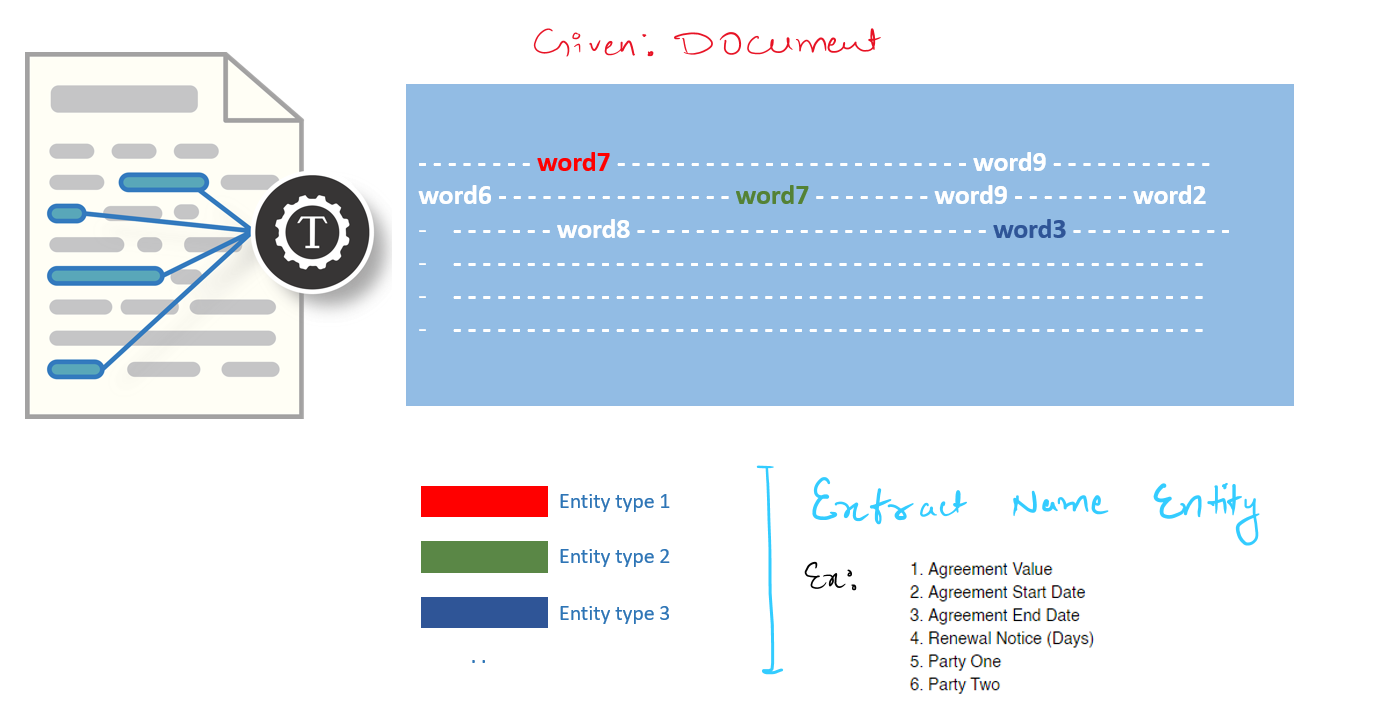

In [1113]:
from IPython.display import Image
Image(filename='../images/illustration.png',width=1200, height=900)

## 3. Dataset Loading and Description

### Description -

#### The rental agreements are in the docx format. The training and evaluation datasets are available at the following location.

* $ workspace/data $ 


The above directory has 2 sub-directories:

* training/: contains a total of 43 rental agreements
* eval/: contains a total of 8 rental agreements

For each training rental agreements docx file we have 6 entities (Aggrement Values, Aggrement Start Date, Aggrement End Date, Rebewal Notice(Days), Party One, Party Two) in a "data/TrainingTestSet .csv" for training and for validation rental agreements docx file there is "data/ValidationSet.csv".

### Dataset Loading

In [911]:
# Ignore all your warnings

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import docx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.util import minibatch, compounding
from spacy.matcher import PhraseMatcher
from spacy.gold import GoldParse 
from spacy.scorer import Scorer

In [2]:
# Load TrainingTestSet and ValidationSet
TrainingTestSet = pd.read_csv('../data/TrainingTestSet .csv')
ValidationSet = pd.read_csv('../data/ValidationSet.csv')

# Sample
print('Shape of TrainingTestSet: ', TrainingTestSet.shape)
print('Shape of ValidationSet: ', ValidationSet.shape)
TrainingTestSet.sample(5)

Shape of TrainingTestSet:  (55, 7)
Shape of ValidationSet:  (8, 7)


,File Name,Aggrement Value,Aggrement Start Date,Aggrement End Date,Renewal Notice (Days),Party One,Party Two
17,54770958-Rental-Agreement,8000.0,01.04.2011,31.03.2012,90.0,K. Parthasarathy,Veerabrahmam Bathini
39,228094620-Rental-Agreement,15000.0,07.07.2013,06.06.2014,30.0,KAPIL MEHROTRA,.B.Kishore
33,156155545-Rental-Agreement-Kns-Home,12000.0,15.12.2012,14.11.2013,30.0,V.K.NATARAJ,VYSHNAVI DAIRY SPECIALITIES Private Ltd
11,24158401-Rental-Agreement,12000.0,01.04.2008,31.03.2009,60.0,Hanumaiah,Vishal Bhardwaj
16,50070534-RENTAL-AGREEMENT (1),10000.0,01.04.2010,30.03.2011,90.0,P. JohnsonRavikumar,Saravanan BV


Note: Files of ValidationSet are overlapping in TrainingTestSet csv file.

In [3]:
# Load Training rental agreements docx file
Training_data_docx = os.listdir('../data/Training_data')
Validation_Data_docx = os.listdir('../data/Validation_Data')

print('Number of training docx: ', len(Training_data_docx))
print('Number of validation docx: ', len(Validation_Data_docx))

Number of training docx:  43
Number of validation docx:  8


In [4]:
# Rent Agreement Sample
idx = 0
file_name = Training_data_docx[idx]
doc = docx.Document(f"../data/Training_data/{file_name}")
full_text_list = [paragraph.text for paragraph in doc.paragraphs]
full_text = " ".join(full_text_list)

print('Sampple\n', '-'*120, '\n', full_text)

# Corresponding Entities
print('\n\n', 'Corresponding Entities\n',  '-'*120,)
TrainingTestSet[TrainingTestSet['File Name'] == file_name.rstrip('.pdf.docx')]

Sampple
 ------------------------------------------------------------------------------------------------------------------------ 
 HOUSE RENTAL AGREEMENT Rental Agreement made on Jan 10, 2011, between Namashivayam, Plat No-182, Door No 16 New/10 Old, 24th East Street, Kamaraj Nagar, Thiruvanmiyur, Chennai (hereinafter referred to as landlord) of the house and Mrs.Thenmalar, W/O Xavier, Kottaikadu (PO), Vadakadu (Via), Pudukkottai (Dt) (hereinafter referred to as tenant) of the First floor portion of the building. WHERE IT IS AGREED AND DECLARED AS FOLLOWS: The Landlord agrees to let out and the tenant agrees to take on rent the First floor portion of the building Plat No-182, Door No 16 New/10 Old, 24th East Street, Kamaraj Nagar, Thiruvanmiyur along with electrical and sanitary fittings and other accessories fittings and structures (hereinafter called the premises) from Jan 10 2011 at the monthly rent of Rs. 14500 (Fourteen thousand and five hundred rupees) being payable on or before

,File Name,Aggrement Value,Aggrement Start Date,Aggrement End Date,Renewal Notice (Days),Party One,Party Two
29,100999172-House-Rental-Agreement,14500.0,10.01.2011,09.01.2012,90.0,Namashivayam,Thenmalar


#### Merge Rental-Agreement doc files and entities from csv files

In [70]:
# Merge Rental-Agreement doc files and entities
def extract_doc_text(doc_list):
    """ Given doc file names, return dataframe of extracted text"""
    file_names = []
    texts = []

    for file in tqdm(doc_list):
        file_name = file.rstrip('.pdf.docx').split('/')[-1]

        doc = docx.Document(file)
        full_text_list = [paragraph.text for paragraph in doc.paragraphs]
        full_text = " ".join(full_text_list)

        file_names.append(file_name)
        texts.append(full_text)
        
    return pd.DataFrame({'File Name': file_names, 'text': texts})

In [1103]:
training_data_docx_list = ["../data/Training_data/" + docx for docx in Training_data_docx]
Validation_Data_docx_list = ["../data/Validation_Data/" + docx for docx in Validation_Data_docx]

# Extracting text from doc file
train_text = extract_doc_text(training_data_docx_list)
val_text = extract_doc_text(Validation_Data_docx_list)

# Sample
print("-"*50)
print("Samples - ")
train_text.sample(5)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 266.43it/s]

--------------------------------------------------
Samples - 


,File Name,text
9,216973836-Rental-Agreement-Sample,"THIS RENTAL AGREEMENT is made on this, the M..."
3,142106117-Rental-Agreement,RENTAL AGREEMENT This agreement of Tenancy is ...
1,116950326-December-2012-Rental-Agreement,ROOM RENTAL AGREEMENT This is a legally bind...
0,100999172-House-Rental-Agreement,HOUSE RENTAL AGREEMENT Rental Agreement made o...
6,18325926-Rental-Agreement-1,RENTAL AGREEMENT This deed of rental...


In [93]:
# Merge Rental-Agreement doc files and entities from csv
train_data = pd.merge(TrainingTestSet, train_text, on = 'File Name', how = 'inner')
val_data = pd.merge(ValidationSet, val_text, on = 'File Name', how = 'inner')

print('shape of train_data: ',  train_data.shape)
print('shape of val_data: ',  val_data.shape)

# Samples
train_data.sample(5)

shape of train_data:  (43, 8)
shape of val_data:  (8, 8)


,File Name,Aggrement Value,Aggrement Start Date,Aggrement End Date,Renewal Notice (Days),Party One,Party Two,text
14,63793679-Rental-Agreement,9000.0,01.09.2011,31.08.2012,NaN,S Parthasarathy,Hari Kiran Tholeti,RENTAL AGREEMENT THIS RENTAL A...
37,294331674-Rental-Agreement,3500.0,17.07.2014,17.06.2015,30.0,MICHAEL DELA CRUZ,CATHERINE CABOCHA,RENTAL AGREEMENT THE AGREEMENT The landlord ag...
27,203615996-Rental-Agreement-Format,3500.0,01.02.2008,31.01.2009,30.0,T.RADHA KRISHNAN,ABHIJIT BHARADWAJ,RENTAL AGREEMENT This Agre...
28,216973836-Rental-Agreement-Sample,15000.0,23.03.2013,23.03.2014,60.0,Kamal,V.Arun Kumar,"THIS RENTAL AGREEMENT is made on this, the M..."
11,62126501-Rental-Agreement,4200.0,23.05.2011,22.04.2012,90.0,M.V Srinivas & M.V Madhumathi,M.V Thirumalesh,RENTAL AGREEMENT This Rental Agreement is made...


## 4. Exploratory Data Analyses and Preprocessing

In [147]:
# Utility function to plot lineplot and distplot using seaborn
def plot_sns(data,feature,color='lightblue',title=None,subtitle=None):
    
    """   
    Utility function to plot lineplot and distplot using seaborn
    
    plot_sns(data,feature,color='lightblue',title=None,subtitle=None):
    
    data = data 
    feature = coulum name
    color = color of plot
    title = Either 'length' or 'number' based on which to plot. Otherwise by default='None'
    subtitle = Either 'train_df' or 'val_df'. Otherwise by default='None'  
    
    """    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # line plot
    sns.lineplot(np.arange(len(data)),data,ax=ax1,color=color)    
    if title=='number':
        ax1.set(xlabel=f"Idx of {feature}", ylabel=f"Number of words in {feature}", title=f'Number of words in {feature} in {subtitle}\n')
    elif title=='length':
        ax1.set(xlabel=f"Idx of {feature}", ylabel=f"Length of {feature}", title=f'Length of {feature} in {subtitle}\n')   
    ax1.grid()

    # distribution plot
    sns.distplot(data,ax=ax2,color=color)
    if title=='number':
        ax2.set(xlabel=f"Number of words in {feature}", ylabel="pdf", title=f'Number of words in {feature} in {subtitle}\n')
    elif title=='length':
        ax2.set(xlabel=f"Length of {feature}", ylabel="pdf", title=f'Length of {feature} in {subtitle}\n')   
    ax2.grid()
    plt.show()
    return None

# Utility function to plot frequency of most popular words
def word_frequency_plot(dataframe, title=None):
    list_of_all_words = []
    for sent in dataframe:
        list_of_all_words.extend(sent.split())

    top_50_words = pd.Series(list_of_all_words).value_counts()[:50]
    top_50_words_prob_dist = top_50_words.values/sum(top_50_words.values)

    #  plot of frequency of polpular words in train
    plt.figure(figsize=(16,7))
    sns.barplot(top_50_words.index, top_50_words_prob_dist)
    plt.xlabel("words")
    plt.ylabel("frequency")
    plt.title(f"Frequency of most popular words {title}\n")
    plt.xticks(rotation=70)
    plt.grid()
    plt.show()
    return None

# Utility function to plot frequency of number of words
def plot_distibution_diff(df1, df2):
    """ Given 2 text dataframe, plot word frequency dist."""
    # Calculating the length of text before and after preprocessing
    len_after_cleaning = df1.apply(lambda x: len(x.split()))
    len_before_cleaning = df2.apply(lambda x: len(x.split()))

    # ploting
    plt.figure(figsize=(9, 6))
    sns.distplot(len_before_cleaning, label='len_before_cleaning')
    sns.distplot(len_after_cleaning, label='len_after_cleaning')
    plt.title(f" Distribution of number of words in text before v/s after preprocessing\n", fontsize=15)
    plt.ylabel("distribtion")
    plt.xlabel(f"number of words in text")
    plt.legend()
    plt.grid()
    plt.show()
    return None


#### 4.1 How many entities are missing?

In [107]:
print('Number of entities missing from training data -')
np.sum(train_data.drop(labels=['File Name', 'text'], axis=1).isnull())

Number of entities missing from training data -


Aggrement Value           1
Aggrement Start Date      3
Aggrement End Date        6
Renewal Notice (Days)    11
Party One                 0
Party Two                 1
dtype: int64

#### 4.2 Distribution of length of text in train and val data

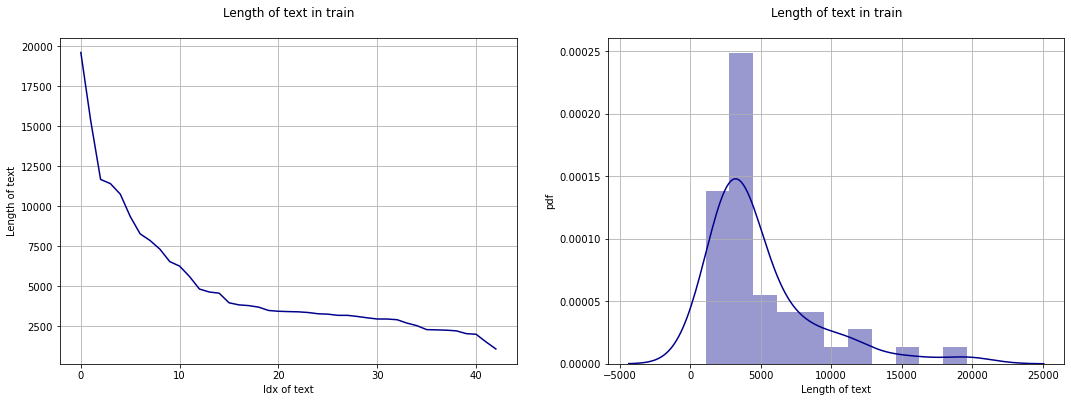

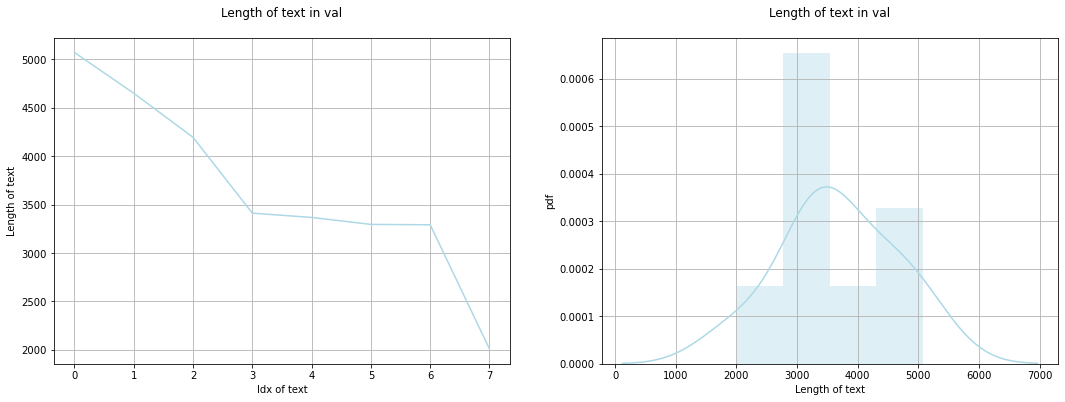

In [141]:
# Length of question_title in train
len_of_text_train = sorted(train_data['text'].apply(lambda x: len(x)),reverse=True)

# Length of question_title in test
len_of_text_val = sorted(val_data['text'].apply(lambda x: len(x)),reverse=True)

# plot for train_df
plot_sns(len_of_text_train,"text",color='darkblue',title='length',subtitle='train')

# plot for test_df
plot_sns(len_of_text_val,"text",color='lightblue',title='length',subtitle='val')

#### 4.3 Distribution of number of words in train and val text data

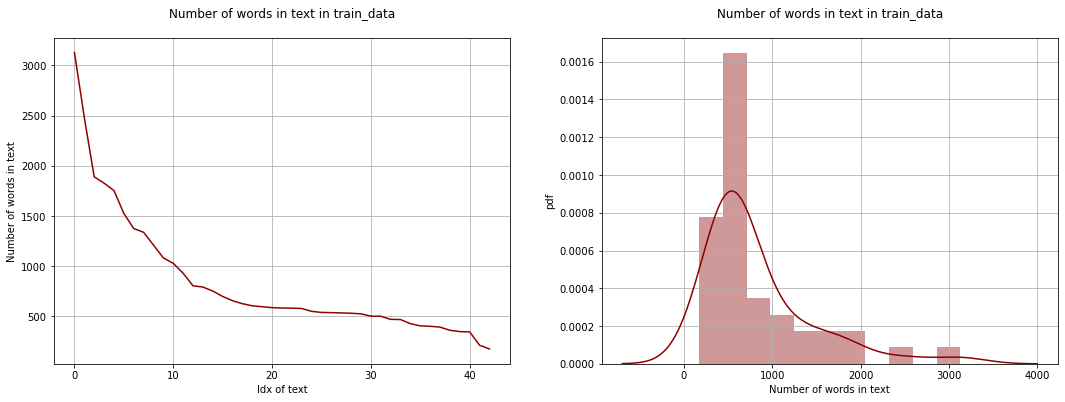

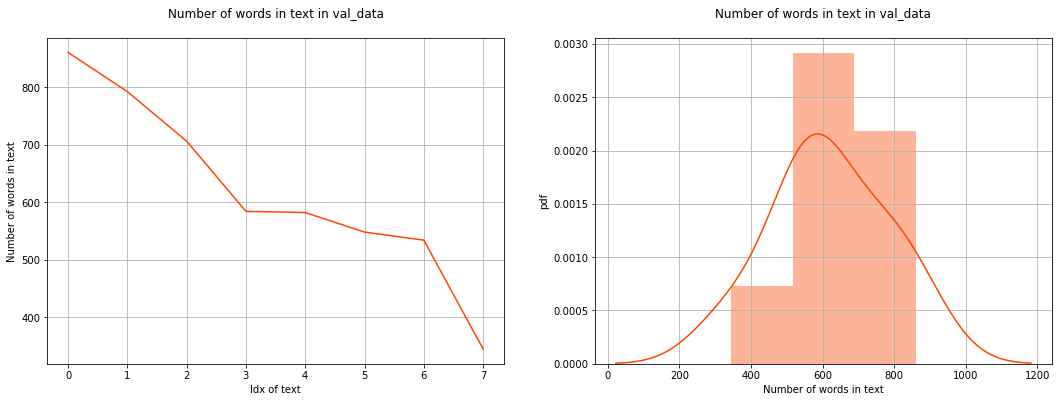

In [145]:
# number of words in question_title in train
n_words_train = sorted(train_data['text'].apply(lambda x: len(x.split(" "))),reverse=True)

# number of words in question_title in test
n_words_val = sorted(val_data['text'].apply(lambda x: len(x.split(" "))),reverse=True)

# plot for train_df
plot_sns(n_words_train,"text",color='darkred',title='number',subtitle='train_data')

# plot for test_df
plot_sns(n_words_val,"text",color='orangered',title='number',subtitle='val_data')

#### 4.4 Frequency of most popular 50 words

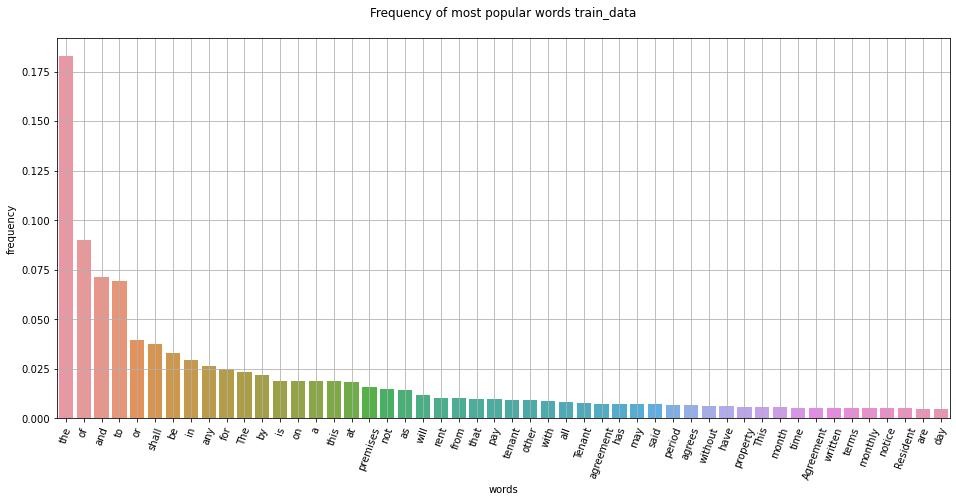

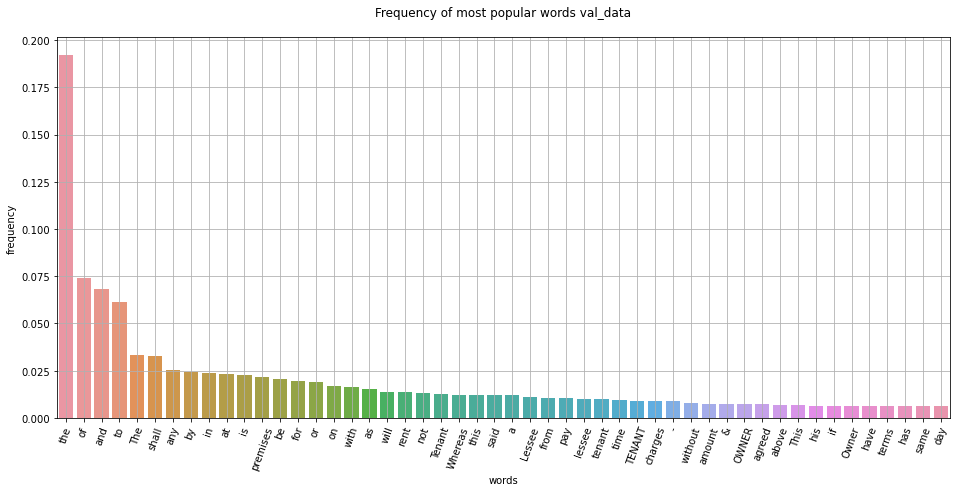

In [148]:
# Frequency of most popular 50 words in train_df
word_frequency_plot(train_data['text'], title='train_data')

# Frequency of most popular words in val_df
word_frequency_plot(val_data['text'], title='val_data')

### Preprocessing and Cleaning data

In [244]:
# Basic Cleaning in text data 
# Train
train_data['cleaned_text'] = train_data['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9-,/.]',' ', x))
train_data['cleaned_text'] = train_data['cleaned_text'].apply(lambda x: " ".join(x.split()))

# Val
val_data['cleaned_text'] = val_data['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9-,/.]',' ', x))
val_data['cleaned_text'] = val_data['cleaned_text'].apply(lambda x: " ".join(x.split()))

Train -


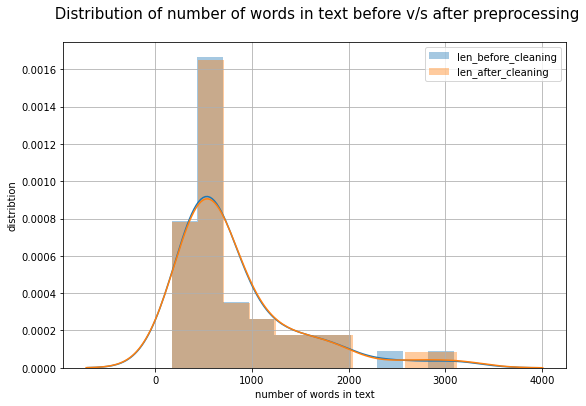

Val -


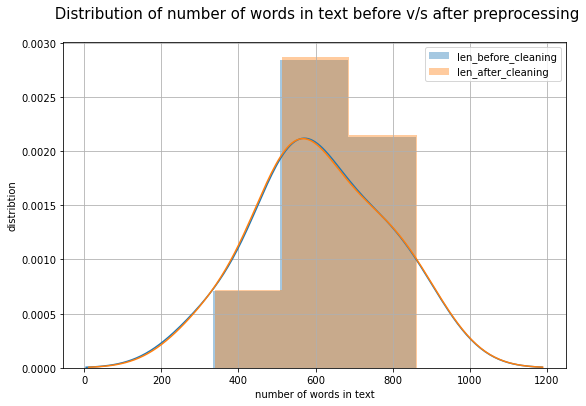

In [247]:
# Distribution before and after performing basic cleaning
print('Train -')
plot_distibution_diff(train_data['cleaned_text'], train_data['text'])
print('Val -')
plot_distibution_diff(val_data['cleaned_text'], val_data['text'])

* Plots are self explanatory

## 5. Making Dataset ready and Modeling

### Approach 1 -
1. Use preprocessed text and find the span of each entity in the rental-agreements docx text file using spacy pattern matcher.
2. Convert the data into required format and finetune Spacy NER.

#### 5.1.1. Converting the data into required format for spacy 

In [255]:
def change_format(df):
    file_names = []
    texts = []
    entities = []

    for idx in tqdm(range(df.shape[0])):
        file_name = df.iloc[idx]['File Name']
        full_text = df.iloc[idx]['cleaned_text']

        entity = {
            'agreement_value': str(df.iloc[idx]['Aggrement Value']),
            'agreement_start_data': str(df.iloc[idx]['Aggrement Start Date']),
            'agreement_end_data': str(df.iloc[idx]['Aggrement End Date']),
            'renewal_notice': str(df.iloc[idx]['Renewal Notice (Days)']),
            'party_one': str(df.iloc[idx]['Party One']),
            'party_two': str(df.iloc[idx]['Party Two'])
        }

        file_names.append(file_name)
        texts.append(full_text)
        entities.append(entity)

    return pd.DataFrame({'filename': file_names, 'text': texts, 'entities': entities})

In [258]:
# Change Format
train_data_changes_format_df = change_format(train_data)
val_data_changes_format_df = change_format(val_data)

# Sample
train_data_changes_format_df.sample(5)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1141.85it/s]


,filename,text,entities
1,6683129-House-Rental-Contract-Geraldine-Galina...,House Rental Contract KNOWN ALL MEN BY THESE P...,"{'agreement_value': '6500.0', 'agreement_start..."
37,294331674-Rental-Agreement,RENTAL AGREEMENT THE AGREEMENT The landlord ag...,"{'agreement_value': '3500.0', 'agreement_start..."
13,63057680-Rental-Agreement,Rental Agreement This agreement made this 19 d...,"{'agreement_value': '450.0', 'agreement_start_..."
27,203615996-Rental-Agreement-Format,RENTAL AGREEMENT This Agreement of Tenancy is ...,"{'agreement_value': '3500.0', 'agreement_start..."
39,323828497-Rental-Agreement-Micky,RENTAL AGREEMENT THIS AGREEMENT made this 27TH...,"{'agreement_value': '800.0', 'agreement_start_..."


#### Percentage of missing entities in training data

In [858]:
def count_percentage_of_missing_entities(df, n_entity=6):
    df_len = df.shape[0]
    count = 0
    for idx in range(df_len):
        for value in df['entities'][idx].values():
            if value == 'nan':
                count += 1

    return count, np.round((count / (df_len * n_entity))*100, 2)

In [888]:
# Count the percentage of nan/missing entities from training data
n_entity = 6
n_missing_enitity, percentage = count_percentage_of_missing_entities(train_data_changes_format_df, n_entity)
print(f"Percentage of nan/missing entities from training data: {n_missing_enitity}/{train_data_changes_format_df.shape[0]*n_entity} {percentage} %")

Percentage of nan/missing entities from training data: 22/258 8.53 %


In [287]:
# Convert the data into required spacy format
def change_spacy_format(df):
    """ 
    Given df, convert into spacy format
    code refer: https://github.com/chawla201/Custom-Named-Entity-Recognition
    """
    training_data = []
    id_ent = []

    nlp_match = spacy.load('en_core_web_sm')
    matcher = PhraseMatcher(nlp_match.vocab)
    for index in tqdm(range(df.shape[0])):
        
        ent_dic = df.iloc[index]["entities"]
        ent = []
        phrases = list(ent_dic.values())
        patterns = [nlp_match.make_doc(phrase) for phrase in phrases]
        matcher.add("EntityList", None, *patterns)

        doc = nlp_match(df.iloc[index]["text"])
        matches = matcher(doc)
        for match_id, start, end in matches:
            try:
                span = doc[start:end]
                if start > 0:
                    sb = doc[0:start]
                    start_index = len(sb.text) + 1
                else:
                    start_index = 0
                end_index = start_index + len(span.text)
            except:
                pass

            for key, value in ent_dic.items():
                if value == span.text:
                    ent_tup = (start_index, end_index, key)
                    ent.append(ent_tup)

        id_ent.append(len(ent))
        entity_dictionary = {"entities": ent}
        train_tup = (df.iloc[index]["text"], entity_dictionary)
        training_data.append(train_tup)
        
    return training_data

In [856]:
# Converting the data into required format for spacy
training_data_spacy_format = change_spacy_format(train_data_changes_format_df)
val_data_spacy_format = change_spacy_format(val_data_changes_format_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.85it/s]


#### Percentage of missing entities in from spacy_format training data

In [884]:
def count_percentage_of_missing_entities_from_spacy_format(spacy_format_data):
    count = 0
    for train_data_file in spacy_format_data:
        count += len(train_data_file[1]['entities'])

    return count

In [896]:
# Calculate Percentage of missing entities in spacy_format training data
n_entity_in_spacy_format_training_data = count_percentage_of_missing_entities_from_spacy_format(training_data_spacy_format)

n_entity_in_spacy_format_training_data_per = np.round((n_entity_in_spacy_format_training_data /
                                            (train_data_changes_format_df.shape[0]*n_entity - n_missing_enitity)*100),3)

print(f'Percentage containing entity in training data: {n_entity_in_spacy_format_training_data_per} %')


Percentage containing entity in training data: 21.186 %


#### Observation - 

* Only 21.186 % entity is able to preserve in the training data when converted the data into spacy required format using spacy patter matcher.

* Clearly spacy patter matcher is not able to annotate the entity properly.

* Let's see how training validation is performing on this half baked annotated data. 

#### 5.1.2. Finetune Spacy-NER Model

In [961]:
import random

def train_model(train_data, n_iter, drop_rate):
    """
    Finetune Spacy-NER model. 
    Code Refer: https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/
    """
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last = True)
    
    for _, annotation in train_data:
        for ent in annotation['entities']:
            ner.add_label(ent[2])
            
    
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            losses = {}
            index = 0
            for text, annotations in train_data:
                try:
                    nlp.update( [text],  
                        [annotations], 
                        drop=drop_rate, 
                        sgd=optimizer, 
                        losses=losses)
                except Exception as e:
                    pass
            print("Iteration " + str(itn+1) + f" -- {str(losses)}")
    return None

In [963]:
# Training spacy model

n_iter = 100 # Number of iteration to train the model
drop_rate = 0.4 # Drop Rate
nlp = spacy.blank('en')
train_model(training_data_spacy_format, n_iter, drop_rate)

  1%|▊                                                                                 | 1/100 [00:04<07:24,  4.49s/it]

Iteration 1 -- {'ner': 6596.153565852916}


  2%|█▋                                                                                | 2/100 [00:08<07:14,  4.44s/it]

Iteration 2 -- {'ner': 174.02712727702692}


  3%|██▍                                                                               | 3/100 [00:13<07:08,  4.41s/it]

Iteration 3 -- {'ner': 86.82722178320466}


  4%|███▎                                                                              | 4/100 [00:17<07:02,  4.40s/it]

Iteration 4 -- {'ner': 78.15242129978515}


  5%|████                                                                              | 5/100 [00:21<06:57,  4.39s/it]

Iteration 5 -- {'ner': 308.3341567920169}


  6%|████▉                                                                             | 6/100 [00:26<06:49,  4.36s/it]

Iteration 6 -- {'ner': 358.96277174856255}


  7%|█████▋                                                                            | 7/100 [00:30<06:43,  4.34s/it]

Iteration 7 -- {'ner': 730.4875832657744}


  8%|██████▌                                                                           | 8/100 [00:34<06:37,  4.32s/it]

Iteration 8 -- {'ner': 341.62460533338214}


  9%|███████▍                                                                          | 9/100 [00:38<06:30,  4.29s/it]

Iteration 9 -- {'ner': 300.2063838363746}


 10%|████████                                                                         | 10/100 [00:43<06:25,  4.28s/it]

Iteration 10 -- {'ner': 449.46417401973076}


 11%|████████▉                                                                        | 11/100 [00:47<06:25,  4.33s/it]

Iteration 11 -- {'ner': 484.5816056098009}


 12%|█████████▋                                                                       | 12/100 [00:52<06:21,  4.33s/it]

Iteration 12 -- {'ner': 264.9103673957442}


 13%|██████████▌                                                                      | 13/100 [00:56<06:17,  4.34s/it]

Iteration 13 -- {'ner': 1730.589461975564}


 14%|███████████▎                                                                     | 14/100 [01:00<06:12,  4.33s/it]

Iteration 14 -- {'ner': 695.8895368451488}


 15%|████████████▏                                                                    | 15/100 [01:05<06:08,  4.33s/it]

Iteration 15 -- {'ner': 585.1288306221687}


 16%|████████████▉                                                                    | 16/100 [01:09<06:02,  4.32s/it]

Iteration 16 -- {'ner': 472.9258818584804}


 17%|█████████████▊                                                                   | 17/100 [01:13<05:58,  4.32s/it]

Iteration 17 -- {'ner': 262.74214103580255}


 18%|██████████████▌                                                                  | 18/100 [01:17<05:54,  4.33s/it]

Iteration 18 -- {'ner': 586.0397549662738}


 19%|███████████████▍                                                                 | 19/100 [01:22<05:49,  4.32s/it]

Iteration 19 -- {'ner': 394.4524349417229}


 20%|████████████████▏                                                                | 20/100 [01:26<05:44,  4.31s/it]

Iteration 20 -- {'ner': 329.29933236597924}


 21%|█████████████████                                                                | 21/100 [01:30<05:41,  4.32s/it]

Iteration 21 -- {'ner': 459.88193141007724}


 22%|█████████████████▊                                                               | 22/100 [01:35<05:38,  4.33s/it]

Iteration 22 -- {'ner': 220.68507656390346}


 23%|██████████████████▋                                                              | 23/100 [01:39<05:34,  4.34s/it]

Iteration 23 -- {'ner': 389.368745528599}


 24%|███████████████████▍                                                             | 24/100 [01:44<05:32,  4.38s/it]

Iteration 24 -- {'ner': 577.5192175878285}


 25%|████████████████████▎                                                            | 25/100 [01:48<05:29,  4.39s/it]

Iteration 25 -- {'ner': 327.49336029904117}


 26%|█████████████████████                                                            | 26/100 [01:52<05:25,  4.39s/it]

Iteration 26 -- {'ner': 230.53747219287908}


 27%|█████████████████████▊                                                           | 27/100 [01:57<05:19,  4.38s/it]

Iteration 27 -- {'ner': 628.4709483853154}


 28%|██████████████████████▋                                                          | 28/100 [02:01<05:14,  4.37s/it]

Iteration 28 -- {'ner': 404.71935699835984}


 29%|███████████████████████▍                                                         | 29/100 [02:05<05:10,  4.37s/it]

Iteration 29 -- {'ner': 265.01919115755896}


 30%|████████████████████████▎                                                        | 30/100 [02:10<05:06,  4.39s/it]

Iteration 30 -- {'ner': 124.9111709353792}


 31%|█████████████████████████                                                        | 31/100 [02:14<05:05,  4.43s/it]

Iteration 31 -- {'ner': 165.27037047389462}


 32%|█████████████████████████▉                                                       | 32/100 [02:19<05:03,  4.47s/it]

Iteration 32 -- {'ner': 304.0826076609532}


 33%|██████████████████████████▋                                                      | 33/100 [02:23<04:59,  4.47s/it]

Iteration 33 -- {'ner': 367.42235551252355}


 34%|███████████████████████████▌                                                     | 34/100 [02:28<04:55,  4.47s/it]

Iteration 34 -- {'ner': 307.2526984500555}


 35%|████████████████████████████▎                                                    | 35/100 [02:32<04:50,  4.46s/it]

Iteration 35 -- {'ner': 80.91087137398841}


 36%|█████████████████████████████▏                                                   | 36/100 [02:37<04:46,  4.47s/it]

Iteration 36 -- {'ner': 43.48938323724138}


 37%|█████████████████████████████▉                                                   | 37/100 [02:41<04:41,  4.47s/it]

Iteration 37 -- {'ner': 225.98934514452708}


 38%|██████████████████████████████▊                                                  | 38/100 [02:46<04:36,  4.46s/it]

Iteration 38 -- {'ner': 102.43324990109319}


 39%|███████████████████████████████▌                                                 | 39/100 [02:50<04:31,  4.46s/it]

Iteration 39 -- {'ner': 231.42875165184378}


 40%|████████████████████████████████▍                                                | 40/100 [02:55<04:27,  4.45s/it]

Iteration 40 -- {'ner': 45.54054780214566}


 41%|█████████████████████████████████▏                                               | 41/100 [02:59<04:23,  4.47s/it]

Iteration 41 -- {'ner': 94.94149010975842}


 42%|██████████████████████████████████                                               | 42/100 [03:04<04:21,  4.50s/it]

Iteration 42 -- {'ner': 51.496606787937736}


 43%|██████████████████████████████████▊                                              | 43/100 [03:08<04:16,  4.49s/it]

Iteration 43 -- {'ner': 70.15730187356914}


 44%|███████████████████████████████████▋                                             | 44/100 [03:13<04:12,  4.51s/it]

Iteration 44 -- {'ner': 62.074041850958295}


 45%|████████████████████████████████████▍                                            | 45/100 [03:17<04:07,  4.50s/it]

Iteration 45 -- {'ner': 56.43847648680074}


 46%|█████████████████████████████████████▎                                           | 46/100 [03:22<04:04,  4.52s/it]

Iteration 46 -- {'ner': 21.041253045160413}


 47%|██████████████████████████████████████                                           | 47/100 [03:26<04:00,  4.54s/it]

Iteration 47 -- {'ner': 58.83355157421643}


 48%|██████████████████████████████████████▉                                          | 48/100 [03:31<03:56,  4.55s/it]

Iteration 48 -- {'ner': 17.961378657741186}


 49%|███████████████████████████████████████▋                                         | 49/100 [03:35<03:50,  4.51s/it]

Iteration 49 -- {'ner': 78.83909988519203}


 50%|████████████████████████████████████████▌                                        | 50/100 [03:40<03:43,  4.46s/it]

Iteration 50 -- {'ner': 29.940757739763}


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:44<03:38,  4.47s/it]

Iteration 51 -- {'ner': 26.717412357122814}


 52%|██████████████████████████████████████████                                       | 52/100 [03:49<03:33,  4.46s/it]

Iteration 52 -- {'ner': 52.545581981180284}


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:53<03:29,  4.46s/it]

Iteration 53 -- {'ner': 21.130594991033977}


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:58<03:25,  4.46s/it]

Iteration 54 -- {'ner': 11.326622326859702}


 55%|████████████████████████████████████████████▌                                    | 55/100 [04:02<03:20,  4.45s/it]

Iteration 55 -- {'ner': 12.213125096696222}


 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:06<03:15,  4.45s/it]

Iteration 56 -- {'ner': 27.859373854441458}


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:11<03:11,  4.45s/it]

Iteration 57 -- {'ner': 38.98854696863546}


 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:15<03:07,  4.46s/it]

Iteration 58 -- {'ner': 18.67661638836517}


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:20<03:02,  4.44s/it]

Iteration 59 -- {'ner': 22.32242058899439}


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:24<02:58,  4.45s/it]

Iteration 60 -- {'ner': 24.84467438005059}


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:29<02:53,  4.44s/it]

Iteration 61 -- {'ner': 12.16121767371058}


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:33<02:48,  4.44s/it]

Iteration 62 -- {'ner': 19.968256095026042}


 63%|███████████████████████████████████████████████████                              | 63/100 [04:38<02:43,  4.43s/it]

Iteration 63 -- {'ner': 32.23497170949467}


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:42<02:38,  4.40s/it]

Iteration 64 -- {'ner': 27.756472212799682}


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:46<02:34,  4.41s/it]

Iteration 65 -- {'ner': 12.28253047110193}


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:51<02:31,  4.46s/it]

Iteration 66 -- {'ner': 11.208153657503019}


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:55<02:27,  4.48s/it]

Iteration 67 -- {'ner': 11.109809125291648}


 68%|███████████████████████████████████████████████████████                          | 68/100 [05:00<02:23,  4.50s/it]

Iteration 68 -- {'ner': 13.41229379904575}


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:04<02:19,  4.49s/it]

Iteration 69 -- {'ner': 16.115826127466995}


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:09<02:14,  4.47s/it]

Iteration 70 -- {'ner': 49.24433199223463}


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:13<02:09,  4.47s/it]

Iteration 71 -- {'ner': 22.60751543155988}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:18<02:05,  4.48s/it]

Iteration 72 -- {'ner': 17.052268802357307}


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:22<02:01,  4.49s/it]

Iteration 73 -- {'ner': 19.686977719653644}


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:27<01:57,  4.51s/it]

Iteration 74 -- {'ner': 25.1797430370473}


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:31<01:52,  4.51s/it]

Iteration 75 -- {'ner': 13.744714054874333}


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:36<01:48,  4.52s/it]

Iteration 76 -- {'ner': 17.355870493309894}


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:41<01:44,  4.54s/it]

Iteration 77 -- {'ner': 2.601828662203171}


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:45<01:39,  4.54s/it]

Iteration 78 -- {'ner': 6.617098737826412}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:50<01:35,  4.53s/it]

Iteration 79 -- {'ner': 6.422928355708622}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:54<01:30,  4.54s/it]

Iteration 80 -- {'ner': 14.85591588278209}


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:59<01:26,  4.54s/it]

Iteration 81 -- {'ner': 1.01312696218806}


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [06:03<01:21,  4.54s/it]

Iteration 82 -- {'ner': 11.266264691817957}


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [06:08<01:17,  4.54s/it]

Iteration 83 -- {'ner': 5.051446836846079}


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [06:12<01:12,  4.50s/it]

Iteration 84 -- {'ner': 5.027146308191458}


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:17<01:07,  4.48s/it]

Iteration 85 -- {'ner': 1.9417035257235007}


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:21<01:02,  4.48s/it]

Iteration 86 -- {'ner': 25.754415197955485}


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:26<00:58,  4.51s/it]

Iteration 87 -- {'ner': 44.38505600528889}


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:30<00:53,  4.49s/it]

Iteration 88 -- {'ner': 44.842011740682075}


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:35<00:49,  4.47s/it]

Iteration 89 -- {'ner': 12.633038548711221}


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:39<00:44,  4.46s/it]

Iteration 90 -- {'ner': 9.571119883952603}


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:43<00:39,  4.44s/it]

Iteration 91 -- {'ner': 1.7070071350223301}


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:48<00:35,  4.44s/it]

Iteration 92 -- {'ner': 2.690981638682182}


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:52<00:31,  4.47s/it]

Iteration 93 -- {'ner': 2.9665370804367894}


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:57<00:26,  4.45s/it]

Iteration 94 -- {'ner': 0.4998133566396886}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [07:01<00:22,  4.46s/it]

Iteration 95 -- {'ner': 7.787075808101306}


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [07:06<00:17,  4.44s/it]

Iteration 96 -- {'ner': 10.640083993438354}


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [07:10<00:13,  4.45s/it]

Iteration 97 -- {'ner': 6.121054668882568}


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [07:15<00:08,  4.44s/it]

Iteration 98 -- {'ner': 11.64663496775421}


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:19<00:04,  4.45s/it]

Iteration 99 -- {'ner': 4.807625320368429}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:23<00:00,  4.44s/it]

Iteration 100 -- {'ner': 23.666107879062498}


In [ ]:
# Saving the model
nlp.to_disk('model1')

In [1107]:
# loading the model
nlp_model = spacy.load('model1')

#### Recall on training data and val data (Given only 21.186 % entity is able to preserve in the training data when converted the data into spacy required format using spacy patter matcher)

In [965]:
def score(spacy_format_data, model):
    """ Function to clacluate recall metric of a model"""
    scorer = Scorer()
    try:
        for input_, annot in spacy_format_data:
            doc_gold_text = model.make_doc(input_)
            gold = GoldParse(doc_gold_text, entities=annot['entities'])
            pred_value = model(input_)
            scorer.score(pred_value, gold)
    except Exception as e: print(e)
    return scorer.scores['ents_r']

In [966]:
# Recall on training data
training_recall_model1 = score(training_data_spacy_format, nlp_model)
print(f"Recall on validation data: {training_recall_model1}")

# Recall on val data
val_recall_model1 = score(val_data_spacy_format, nlp_model)
print(f"Recall on validation data: {val_recall_model1}")

Recall on validation data: 100.0
Recall on validation data: 90.9090909090909


In [967]:
# Prediction on val data
for idx, data_point in enumerate(val_data_spacy_format):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
----------------------------------------------------------------------------------------------------
2 filename-  63793679-Rental-Agreement
PARTY_ONE                     - S Parthasarathy
PARTY_TWO                     - Hari Kiran Tholeti
PARTY_ONE                     - S Parthasarathy
PARTY_ONE                     - S Parthasarathy
PARTY_TWO                     - Hari Kiran Tholeti
----------------------------------------------------------------------------------------------------
3 filename-  95980236-Rental-Agreement
PARTY_TWO                     - V.V.Ravi Kian
----------------------------------------------------------------------------------------------------
4 filename-  156155545-Rental-Agreement-Kns-Home
----------------------------------------------------------------------------------------------------
5 filename-  195231682-This-RENTAL-AGREEMENT-is-Made-and-Executed-on-24th-Day-of-September
PARTY_ONE                     - C.BHAGYAMMA
PAR

#### Observation - 

1. As expected approach 1 has badly failed to extract metainfor from rental agreement.


2. Although training recall and validation recall of model is high but while prediction six fields on validation data, model is hardly able to predict PARTY_ONE and PARTY_TWO and in some scenario even those fileds are not getting predicted.


3. Reason in simple. We have poorly annotated training data which we have created using spacy pattern matcher.


4. We have ambigious entities in TrainingSet csv and given corresponding docx file. E.g, data 10.5.2011 != 10-05-2011 != 10/05/2011 != 10th may of 2011.


5. Potential Solution - Prepare better annotated data for training.

### Approach 2 -
1. Use pretrained model which is trained on similar dataset.
2. Perform pseudo annotation of training text and val text.
3. Use Pseudo annotated data for training and observe the prediction.

### Pretrained model which is trained on similar dataset.

Source: https://github.com/sanghavi-vemulapati/Rental-Agreement-Metadata-extraction-using-spacy
        
* Author of this person has gone through mannual annotation on training data using Label Studio and trained Spacy-NER model on the top of that.

* But only problem is that author has used 8 entity fileds rather that 6 entity fileds which is our case. Let's see how can we tackle that problem.

In [944]:
def pseudo_annotation(df, pseudo_model):
    """ 
    Give a pretrained model and dataframe containing cleaned_text, 
    this function pseudo_annotate the data.
    """
    pseudo_annotated_data = []

    df_len = df.shape[0]
    for idx in range(df_len):
        doc = pseudo_model(df['cleaned_text'].iloc[idx])

        entity = []
        for ent in doc.ents:

            if ent.label_.upper() == 'PARTYONE':
                entity.append((ent.start_char, ent.end_char, 'party_one'))

            if ent.label_.upper() == 'PARTYTWO':
                entity.append((ent.start_char, ent.end_char, 'party_two'))

            if ent.label_.upper() == 'STARTDATE':
                entity.append((ent.start_char, ent.end_char, 'agreement_start_data'))

            if ent.label_.upper() == 'ENDDATE':
                entity.append((ent.start_char, ent.end_char, 'agreement_end_data'))

            if ent.label_.upper() == 'NOTICE':
                entity.append((ent.start_char, ent.end_char, 'renewal_notice'))

            if ent.label_.upper() == 'AGREEMENTVALUE':
                entity.append((ent.start_char, ent.end_char, 'agreement_value'))

        pseudo_annotated_data.append((df['cleaned_text'].iloc[idx], {'entities': entity}))
    return pseudo_annotated_data

In [945]:
# loading the pretrained model foe pseudo annotation of data
nlp_pretrained_model_pseudo = spacy.load('pretrained_model_pseudo_annotation')

#### 5.2.1. Pseudo Annotatiion

In [951]:
# Pseudo Annotation
pseudo_annotated_data_training_data = pseudo_annotation(train_data, nlp_pretrained_model_pseudo)
pseudo_annotated_data_val_data = pseudo_annotation(val_data, nlp_pretrained_model_pseudo)

In [955]:
# Sample
print('Pseudo annotated data Sample - ')
pseudo_annotated_data_training_data[0]

Pseudo annotated data Sample - 


('House Rental Contract KNOWN ALL MEN BY THESE PRESENTS This House Rental Contract, made and entered into this 20th day of May 2007 at Manila by and between Antonio Levy S. Ingles. Jr. and/or Mary Rose C. Ingles, of legal age, with residence and postal address at Unit 2006 EGI Taft Tower 2339 Taft Avenue, Malate, Manila, And herein referred to as the Owner s , And GERALDINE O. GALINATO. of legal age, with residence and postal address at 6 Manganese Road, Pilar Village, Las Pinas, Metro Manila, And herein referred to as the Resident s , WITNESSETH In consideration of the agreements of the Resident s , known as GERALDINE O. GALINATO. the Owner s , known as Antonio Levy S. Ingles. Jr. and/or Mary Rose C. Ingles, hereby rent their the dwelling/house located at Lot 6, Block 20, Royal South Townhomes, Marcos Alvarez Avenue, Talon 5, Las Pinas City, Metro Manila for the period commencing on the 20th day of May, 2007, and monthly thereafter until the 20th day of May, 2008, at which time this A

#### 5.2.2. Training the model on pseudo_annotated_data_training_data

In [956]:
import random

# Number of iteration to train the model
n_iter = 100
drop_rate = 0.4 # Drop Rate
nlp = spacy.blank('en')

# Training spacy model on pseudo annotated data
train_model(pseudo_annotated_data_training_data, n_iter, drop_rate)

# Saving the model
nlp.to_disk('model2')

# loading the mode
nlp_model2 = spacy.load('model2')

  1%|▊                                                                                 | 1/100 [00:04<07:39,  4.64s/it]

Iteration 1 -- {'ner': 11501.767158730307}


  2%|█▋                                                                                | 2/100 [00:08<07:26,  4.56s/it]

Iteration 2 -- {'ner': 926.2736926298376}


  3%|██▍                                                                               | 3/100 [00:13<07:20,  4.54s/it]

Iteration 3 -- {'ner': 1235.0912636656951}


  4%|███▎                                                                              | 4/100 [00:17<07:10,  4.49s/it]

Iteration 4 -- {'ner': 1555.955250399003}


  5%|████                                                                              | 5/100 [00:22<07:03,  4.46s/it]

Iteration 5 -- {'ner': 2649.0714719340763}


  6%|████▉                                                                             | 6/100 [00:26<06:58,  4.45s/it]

Iteration 6 -- {'ner': 4880.075084735612}


  7%|█████▋                                                                            | 7/100 [00:31<06:54,  4.45s/it]

Iteration 7 -- {'ner': 4948.456901875237}


  8%|██████▌                                                                           | 8/100 [00:35<06:48,  4.44s/it]

Iteration 8 -- {'ner': 3333.228643601755}


  9%|███████▍                                                                          | 9/100 [00:39<06:43,  4.43s/it]

Iteration 9 -- {'ner': 6530.776144366049}


 10%|████████                                                                         | 10/100 [00:44<06:42,  4.47s/it]

Iteration 10 -- {'ner': 4222.114024875459}


 11%|████████▉                                                                        | 11/100 [00:48<06:36,  4.45s/it]

Iteration 11 -- {'ner': 3353.103759642134}


 12%|█████████▋                                                                       | 12/100 [00:53<06:28,  4.42s/it]

Iteration 12 -- {'ner': 4244.441163302188}


 13%|██████████▌                                                                      | 13/100 [00:57<06:24,  4.41s/it]

Iteration 13 -- {'ner': 5862.1701586059635}


 14%|███████████▎                                                                     | 14/100 [01:02<06:19,  4.41s/it]

Iteration 14 -- {'ner': 3534.778282644491}


 15%|████████████▏                                                                    | 15/100 [01:06<06:13,  4.39s/it]

Iteration 15 -- {'ner': 4495.838792919998}


 16%|████████████▉                                                                    | 16/100 [01:10<06:09,  4.40s/it]

Iteration 16 -- {'ner': 6266.101924069069}


 17%|█████████████▊                                                                   | 17/100 [01:15<06:07,  4.43s/it]

Iteration 17 -- {'ner': 4097.907610005313}


 18%|██████████████▌                                                                  | 18/100 [01:19<06:02,  4.42s/it]

Iteration 18 -- {'ner': 3629.5486463047196}


 19%|███████████████▍                                                                 | 19/100 [01:24<05:59,  4.44s/it]

Iteration 19 -- {'ner': 3754.7919811999213}


 20%|████████████████▏                                                                | 20/100 [01:28<05:52,  4.41s/it]

Iteration 20 -- {'ner': 3678.099803828094}


 21%|█████████████████                                                                | 21/100 [01:32<05:47,  4.39s/it]

Iteration 21 -- {'ner': 4083.2391386963413}


 22%|█████████████████▊                                                               | 22/100 [01:37<05:41,  4.38s/it]

Iteration 22 -- {'ner': 4071.9648092132757}


 23%|██████████████████▋                                                              | 23/100 [01:41<05:36,  4.37s/it]

Iteration 23 -- {'ner': 4744.446259863238}


 24%|███████████████████▍                                                             | 24/100 [01:46<05:33,  4.39s/it]

Iteration 24 -- {'ner': 5764.8809443240425}


 25%|████████████████████▎                                                            | 25/100 [01:50<05:27,  4.36s/it]

Iteration 25 -- {'ner': 3250.487087033631}


 26%|█████████████████████                                                            | 26/100 [01:54<05:25,  4.39s/it]

Iteration 26 -- {'ner': 3527.1403671773533}


 27%|█████████████████████▊                                                           | 27/100 [01:59<05:19,  4.37s/it]

Iteration 27 -- {'ner': 4032.1499717874585}


 28%|██████████████████████▋                                                          | 28/100 [02:03<05:16,  4.39s/it]

Iteration 28 -- {'ner': 4110.9771711237545}


 29%|███████████████████████▍                                                         | 29/100 [02:07<05:10,  4.37s/it]

Iteration 29 -- {'ner': 4188.128310194891}


 30%|████████████████████████▎                                                        | 30/100 [02:12<05:06,  4.38s/it]

Iteration 30 -- {'ner': 4212.655841349567}


 31%|█████████████████████████                                                        | 31/100 [02:16<05:02,  4.39s/it]

Iteration 31 -- {'ner': 4810.919377332524}


 32%|█████████████████████████▉                                                       | 32/100 [02:21<04:57,  4.37s/it]

Iteration 32 -- {'ner': 3445.3908700124634}


 33%|██████████████████████████▋                                                      | 33/100 [02:25<04:53,  4.37s/it]

Iteration 33 -- {'ner': 4366.772513571376}


 34%|███████████████████████████▌                                                     | 34/100 [02:29<04:49,  4.39s/it]

Iteration 34 -- {'ner': 2918.4027291478887}


 35%|████████████████████████████▎                                                    | 35/100 [02:34<04:45,  4.40s/it]

Iteration 35 -- {'ner': 3710.929278062174}


 36%|█████████████████████████████▏                                                   | 36/100 [02:38<04:41,  4.40s/it]

Iteration 36 -- {'ner': 3337.523577460239}


 37%|█████████████████████████████▉                                                   | 37/100 [02:43<04:38,  4.42s/it]

Iteration 37 -- {'ner': 3694.0057305984856}


 38%|██████████████████████████████▊                                                  | 38/100 [02:47<04:32,  4.40s/it]

Iteration 38 -- {'ner': 3234.7657213777766}


 39%|███████████████████████████████▌                                                 | 39/100 [02:51<04:30,  4.43s/it]

Iteration 39 -- {'ner': 3662.5680121818696}


 40%|████████████████████████████████▍                                                | 40/100 [02:56<04:26,  4.43s/it]

Iteration 40 -- {'ner': 3746.120977931336}


 41%|█████████████████████████████████▏                                               | 41/100 [03:00<04:20,  4.41s/it]

Iteration 41 -- {'ner': 3952.491953554721}


 42%|██████████████████████████████████                                               | 42/100 [03:05<04:16,  4.42s/it]

Iteration 42 -- {'ner': 2307.8016993155147}


 43%|██████████████████████████████████▊                                              | 43/100 [03:09<04:11,  4.42s/it]

Iteration 43 -- {'ner': 2711.2019293498734}


 44%|███████████████████████████████████▋                                             | 44/100 [03:14<04:06,  4.41s/it]

Iteration 44 -- {'ner': 3018.4278322013874}


 45%|████████████████████████████████████▍                                            | 45/100 [03:18<04:02,  4.41s/it]

Iteration 45 -- {'ner': 2297.1687628946265}


 46%|█████████████████████████████████████▎                                           | 46/100 [03:22<03:57,  4.40s/it]

Iteration 46 -- {'ner': 3966.2840885513588}


 47%|██████████████████████████████████████                                           | 47/100 [03:27<03:52,  4.40s/it]

Iteration 47 -- {'ner': 2176.5798216707653}


 48%|██████████████████████████████████████▉                                          | 48/100 [03:31<03:47,  4.37s/it]

Iteration 48 -- {'ner': 2293.4240015151026}


 49%|███████████████████████████████████████▋                                         | 49/100 [03:35<03:43,  4.38s/it]

Iteration 49 -- {'ner': 2263.6942914724273}


 50%|████████████████████████████████████████▌                                        | 50/100 [03:40<03:38,  4.38s/it]

Iteration 50 -- {'ner': 2568.3368687174247}


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:44<03:34,  4.38s/it]

Iteration 51 -- {'ner': 1458.5021812257987}


 52%|██████████████████████████████████████████                                       | 52/100 [03:49<03:29,  4.37s/it]

Iteration 52 -- {'ner': 1135.7289183397274}


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:53<03:26,  4.40s/it]

Iteration 53 -- {'ner': 2118.646393625113}


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:57<03:22,  4.40s/it]

Iteration 54 -- {'ner': 1292.4091103036803}


 55%|████████████████████████████████████████████▌                                    | 55/100 [04:02<03:17,  4.40s/it]

Iteration 55 -- {'ner': 1694.272591069598}


 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:06<03:13,  4.39s/it]

Iteration 56 -- {'ner': 1087.555334963205}


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:11<03:08,  4.39s/it]

Iteration 57 -- {'ner': 1090.9981928334248}


 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:15<03:04,  4.38s/it]

Iteration 58 -- {'ner': 849.4668447108777}


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:19<03:00,  4.41s/it]

Iteration 59 -- {'ner': 684.9749304270246}


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:24<02:54,  4.37s/it]

Iteration 60 -- {'ner': 793.8138097091003}


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:28<02:50,  4.38s/it]

Iteration 61 -- {'ner': 815.3422597373482}


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:32<02:46,  4.38s/it]

Iteration 62 -- {'ner': 831.0690491061023}


 63%|███████████████████████████████████████████████████                              | 63/100 [04:37<02:41,  4.36s/it]

Iteration 63 -- {'ner': 1132.7905743864324}


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:41<02:37,  4.38s/it]

Iteration 64 -- {'ner': 893.3889358284209}


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:46<02:33,  4.38s/it]

Iteration 65 -- {'ner': 1016.9848860143037}


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:50<02:28,  4.37s/it]

Iteration 66 -- {'ner': 654.6730324101532}


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:54<02:24,  4.39s/it]

Iteration 67 -- {'ner': 699.8555301114511}


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:59<02:20,  4.38s/it]

Iteration 68 -- {'ner': 1123.6239190957558}


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:03<02:15,  4.38s/it]

Iteration 69 -- {'ner': 639.9095469001375}


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:07<02:09,  4.32s/it]

Iteration 70 -- {'ner': 571.2886630399146}


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:12<02:05,  4.34s/it]

Iteration 71 -- {'ner': 886.7045670656865}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:16<02:02,  4.37s/it]

Iteration 72 -- {'ner': 466.57857754592595}


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:21<01:58,  4.38s/it]

Iteration 73 -- {'ner': 514.8248126897786}


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:25<01:54,  4.41s/it]

Iteration 74 -- {'ner': 502.5889265994351}


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:29<01:50,  4.42s/it]

Iteration 75 -- {'ner': 556.5264510932074}


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:34<01:49,  4.56s/it]

Iteration 76 -- {'ner': 442.73868892685897}


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:39<01:44,  4.56s/it]

Iteration 77 -- {'ner': 487.4256997385788}


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:43<01:40,  4.55s/it]

Iteration 78 -- {'ner': 568.0181440136726}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:48<01:35,  4.53s/it]

Iteration 79 -- {'ner': 424.3268673129989}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:52<01:30,  4.51s/it]

Iteration 80 -- {'ner': 596.8845035537834}


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:57<01:26,  4.53s/it]

Iteration 81 -- {'ner': 793.0202736455788}


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [06:01<01:21,  4.51s/it]

Iteration 82 -- {'ner': 384.0994140359706}


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [06:06<01:17,  4.53s/it]

Iteration 83 -- {'ner': 513.9992319140526}


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [06:11<01:12,  4.54s/it]

Iteration 84 -- {'ner': 394.34162059116574}


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:15<01:07,  4.53s/it]

Iteration 85 -- {'ner': 345.8932800400572}


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:20<01:03,  4.55s/it]

Iteration 86 -- {'ner': 428.4442598853578}


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:24<00:59,  4.55s/it]

Iteration 87 -- {'ner': 386.31626133986146}


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:29<00:54,  4.57s/it]

Iteration 88 -- {'ner': 218.0217877506144}


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:33<00:50,  4.58s/it]

Iteration 89 -- {'ner': 444.5541337731298}


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:38<00:45,  4.60s/it]

Iteration 90 -- {'ner': 439.9214341261595}


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:43<00:41,  4.58s/it]

Iteration 91 -- {'ner': 459.4500935271837}


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:47<00:36,  4.61s/it]

Iteration 92 -- {'ner': 936.2307875951349}


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:52<00:32,  4.62s/it]

Iteration 93 -- {'ner': 405.7915223696094}


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:56<00:27,  4.60s/it]

Iteration 94 -- {'ner': 325.02716489292425}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [07:01<00:23,  4.62s/it]

Iteration 95 -- {'ner': 386.6013782724846}


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [07:06<00:18,  4.62s/it]

Iteration 96 -- {'ner': 860.2015856261911}


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [07:10<00:13,  4.64s/it]

Iteration 97 -- {'ner': 222.24190868773672}


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [07:15<00:09,  4.65s/it]

Iteration 98 -- {'ner': 498.9836463508146}


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:20<00:04,  4.63s/it]

Iteration 99 -- {'ner': 262.745389015325}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.45s/it]

Iteration 100 -- {'ner': 268.8925988875858}


In [959]:
# Recall on training data - Pseudo annotated data
training_recall_model2 = score(pseudo_annotated_data_training_data, nlp_model2)
print(f"Recall on validation data: {training_recall_model2}")

# Recall on val data - Pseudo annotated data
val_recall_model2 = score(pseudo_annotated_data_val_data, nlp_model2)
print(f"Recall on validation data: {val_recall_model2}")

Recall on validation data: 96.21621621621622
Recall on validation data: 75.75757575757575


#### Prediction on val data

In [960]:
# Prediction on val data - Pseudo annotated data
for idx, data_point in enumerate(val_data_spacy_format):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model2(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
PARTY_TWO                     - Sri Vishal Bhardwaj
AGREEMENT_VALUE               - Rs 12000 Twelve thousand
AGREEMENT_START_DATA          - 1st April 2008
RENEWAL_NOTICE                - two months
----------------------------------------------------------------------------------------------------
2 filename-  63793679-Rental-Agreement
PARTY_ONE                     - Mr. S Parthasarathy
PARTY_TWO                     - Mr. Hari Kiran Tholeti
AGREEMENT_VALUE               - Rs.9,000/- Rupees Nine Thousand only
AGREEMENT_START_DATA          - 1st September 2011
----------------------------------------------------------------------------------------------------
3 filename-  95980236-Rental-Agreement
PARTY_ONE                     - Mrs. S.Sakunthala
PARTY_TWO                     - V.V.Ravi Kian
AGREEMENT_START_DATA          - 1st April 2010
AGREEMENT_VALUE               - Rs. 9,000/- Nine thousand and two hundred rupees only
RENEWAL_NOTICE            

#### Observation - 

*  Recall on pseudo annoted labeled data is dropped in approach 2 as compare to approach 1 but prediction on validation data is definitely improved. 

* Now, It is able to to predict more than 'PARTY_ONE' and 'PARTY_TWO' entity field.


#### Let's try retraining the same model (approach - 2) with (drop_rate = 0.2)

#### 5.2.3. Training the model on pseudo_annotated_data_training_data (drop_rate = 0.2)

In [969]:
import random

# Number of iteration to train the model
n_iter = 100
drop_rate = 0.2 # Drop Rate
nlp = spacy.blank('en')

# Training spacy model on pseudo annotated data
train_model(pseudo_annotated_data_training_data, n_iter, drop_rate)

# Saving the model
nlp.to_disk('model2')

# loading the model
nlp_model2 = spacy.load('model2')

  1%|▊                                                                                 | 1/100 [00:04<07:23,  4.48s/it]

Iteration 1 -- {'ner': 9473.041992596649}


  2%|█▋                                                                                | 2/100 [00:08<07:18,  4.47s/it]

Iteration 2 -- {'ner': 1905.2746117800348}


  3%|██▍                                                                               | 3/100 [00:13<07:14,  4.48s/it]

Iteration 3 -- {'ner': 3821.085217280388}


  4%|███▎                                                                              | 4/100 [00:17<07:06,  4.45s/it]

Iteration 4 -- {'ner': 2419.1079517698854}


  5%|████                                                                              | 5/100 [00:22<07:02,  4.45s/it]

Iteration 5 -- {'ner': 3968.509851455864}


  6%|████▉                                                                             | 6/100 [00:26<06:55,  4.42s/it]

Iteration 6 -- {'ner': 3944.5375016446933}


  7%|█████▋                                                                            | 7/100 [00:30<06:48,  4.39s/it]

Iteration 7 -- {'ner': 4445.685324044785}


  8%|██████▌                                                                           | 8/100 [00:35<06:45,  4.41s/it]

Iteration 8 -- {'ner': 3601.2669053354093}


  9%|███████▍                                                                          | 9/100 [00:39<06:40,  4.41s/it]

Iteration 9 -- {'ner': 4842.377520717997}


 10%|████████                                                                         | 10/100 [00:44<06:38,  4.43s/it]

Iteration 10 -- {'ner': 4076.3025662059217}


 11%|████████▉                                                                        | 11/100 [00:48<06:34,  4.43s/it]

Iteration 11 -- {'ner': 3305.621291322306}


 12%|█████████▋                                                                       | 12/100 [00:53<06:28,  4.42s/it]

Iteration 12 -- {'ner': 5424.336787951297}


 13%|██████████▌                                                                      | 13/100 [00:57<06:23,  4.41s/it]

Iteration 13 -- {'ner': 4213.330270466221}


 14%|███████████▎                                                                     | 14/100 [01:01<06:18,  4.40s/it]

Iteration 14 -- {'ner': 3280.688188977907}


 15%|████████████▏                                                                    | 15/100 [01:06<06:12,  4.39s/it]

Iteration 15 -- {'ner': 4528.442912941609}


 16%|████████████▉                                                                    | 16/100 [01:10<06:06,  4.37s/it]

Iteration 16 -- {'ner': 9864.289835499076}


 17%|█████████████▊                                                                   | 17/100 [01:15<06:04,  4.40s/it]

Iteration 17 -- {'ner': 3462.6920289440795}


 18%|██████████████▌                                                                  | 18/100 [01:19<06:03,  4.43s/it]

Iteration 18 -- {'ner': 4113.266799872144}


 19%|███████████████▍                                                                 | 19/100 [01:23<05:57,  4.42s/it]

Iteration 19 -- {'ner': 3108.5879776808333}


 20%|████████████████▏                                                                | 20/100 [01:28<05:52,  4.40s/it]

Iteration 20 -- {'ner': 4205.742845265842}


 21%|█████████████████                                                                | 21/100 [01:32<05:47,  4.39s/it]

Iteration 21 -- {'ner': 3876.611389566997}


 22%|█████████████████▊                                                               | 22/100 [01:36<05:40,  4.36s/it]

Iteration 22 -- {'ner': 2538.5743676084544}


 23%|██████████████████▋                                                              | 23/100 [01:41<05:37,  4.38s/it]

Iteration 23 -- {'ner': 3292.8375772849017}


 24%|███████████████████▍                                                             | 24/100 [01:45<05:35,  4.42s/it]

Iteration 24 -- {'ner': 4180.8114981365925}


 25%|████████████████████▎                                                            | 25/100 [01:50<05:29,  4.40s/it]

Iteration 25 -- {'ner': 2408.382382701643}


 26%|█████████████████████                                                            | 26/100 [01:54<05:27,  4.43s/it]

Iteration 26 -- {'ner': 1743.7531023039778}


 27%|█████████████████████▊                                                           | 27/100 [01:59<05:23,  4.43s/it]

Iteration 27 -- {'ner': 1477.8308085226981}


 28%|██████████████████████▋                                                          | 28/100 [02:03<05:18,  4.43s/it]

Iteration 28 -- {'ner': 1777.8402677980623}


 29%|███████████████████████▍                                                         | 29/100 [02:07<05:12,  4.41s/it]

Iteration 29 -- {'ner': 1304.1785412226268}


 30%|████████████████████████▎                                                        | 30/100 [02:12<05:07,  4.39s/it]

Iteration 30 -- {'ner': 754.5745296103074}


 31%|█████████████████████████                                                        | 31/100 [02:16<05:03,  4.39s/it]

Iteration 31 -- {'ner': 945.0634615134222}


 32%|█████████████████████████▉                                                       | 32/100 [02:21<04:59,  4.40s/it]

Iteration 32 -- {'ner': 1083.1761532281753}


 33%|██████████████████████████▋                                                      | 33/100 [02:25<04:55,  4.41s/it]

Iteration 33 -- {'ner': 712.6728564359064}


 34%|███████████████████████████▌                                                     | 34/100 [02:29<04:52,  4.43s/it]

Iteration 34 -- {'ner': 663.546561847309}


 35%|████████████████████████████▎                                                    | 35/100 [02:34<04:47,  4.43s/it]

Iteration 35 -- {'ner': 521.9213426338313}


 36%|█████████████████████████████▏                                                   | 36/100 [02:38<04:43,  4.43s/it]

Iteration 36 -- {'ner': 537.6058088487962}


 37%|█████████████████████████████▉                                                   | 37/100 [02:43<04:38,  4.43s/it]

Iteration 37 -- {'ner': 579.2171538528312}


 38%|██████████████████████████████▊                                                  | 38/100 [02:47<04:31,  4.38s/it]

Iteration 38 -- {'ner': 450.16586499854736}


 39%|███████████████████████████████▌                                                 | 39/100 [02:52<04:36,  4.53s/it]

Iteration 39 -- {'ner': 209.19614385757168}


 40%|████████████████████████████████▍                                                | 40/100 [02:56<04:28,  4.48s/it]

Iteration 40 -- {'ner': 399.7993748501807}


 41%|█████████████████████████████████▏                                               | 41/100 [03:01<04:24,  4.48s/it]

Iteration 41 -- {'ner': 506.8911697977195}


 42%|██████████████████████████████████                                               | 42/100 [03:05<04:18,  4.46s/it]

Iteration 42 -- {'ner': 277.9247688541696}


 43%|██████████████████████████████████▊                                              | 43/100 [03:10<04:14,  4.46s/it]

Iteration 43 -- {'ner': 599.0139246280012}


 44%|███████████████████████████████████▋                                             | 44/100 [03:14<04:11,  4.49s/it]

Iteration 44 -- {'ner': 223.3639653359161}


 45%|████████████████████████████████████▍                                            | 45/100 [03:19<04:06,  4.49s/it]

Iteration 45 -- {'ner': 281.80734536071395}


 46%|█████████████████████████████████████▎                                           | 46/100 [03:23<04:02,  4.50s/it]

Iteration 46 -- {'ner': 1033.3451862328702}


 47%|██████████████████████████████████████                                           | 47/100 [03:28<03:57,  4.48s/it]

Iteration 47 -- {'ner': 215.84220755227375}


 48%|██████████████████████████████████████▉                                          | 48/100 [03:32<03:54,  4.50s/it]

Iteration 48 -- {'ner': 388.9494194648543}


 49%|███████████████████████████████████████▋                                         | 49/100 [03:37<03:49,  4.50s/it]

Iteration 49 -- {'ner': 364.0611969138783}


 50%|████████████████████████████████████████▌                                        | 50/100 [03:41<03:46,  4.52s/it]

Iteration 50 -- {'ner': 278.66692816916253}


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:46<03:42,  4.53s/it]

Iteration 51 -- {'ner': 217.74762516001047}


 52%|██████████████████████████████████████████                                       | 52/100 [03:50<03:38,  4.56s/it]

Iteration 52 -- {'ner': 2334.259093697848}


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:55<03:35,  4.58s/it]

Iteration 53 -- {'ner': 171.4056051506001}


 54%|███████████████████████████████████████████▋                                     | 54/100 [04:00<03:32,  4.61s/it]

Iteration 54 -- {'ner': 1238.087268526897}


 55%|████████████████████████████████████████████▌                                    | 55/100 [04:04<03:25,  4.57s/it]

Iteration 55 -- {'ner': 174.69487442397244}


 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:09<03:21,  4.59s/it]

Iteration 56 -- {'ner': 272.9274950899182}


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:13<03:17,  4.59s/it]

Iteration 57 -- {'ner': 284.09151861849233}


 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:18<03:14,  4.64s/it]

Iteration 58 -- {'ner': 2049.1422846779324}


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:23<03:09,  4.63s/it]

Iteration 59 -- {'ner': 456.30397924433}


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:28<03:06,  4.66s/it]

Iteration 60 -- {'ner': 134.16955784998547}


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:32<03:01,  4.65s/it]

Iteration 61 -- {'ner': 147.33136126042442}


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:37<02:56,  4.63s/it]

Iteration 62 -- {'ner': 200.4496310818133}


 63%|███████████████████████████████████████████████████                              | 63/100 [04:42<02:52,  4.66s/it]

Iteration 63 -- {'ner': 192.10933975480322}


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:46<02:47,  4.66s/it]

Iteration 64 -- {'ner': 345.99439189286966}


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:51<02:42,  4.63s/it]

Iteration 65 -- {'ner': 99.18548575257519}


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:55<02:36,  4.60s/it]

Iteration 66 -- {'ner': 136.6932953202886}


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [05:00<02:31,  4.60s/it]

Iteration 67 -- {'ner': 133.74024668360292}


 68%|███████████████████████████████████████████████████████                          | 68/100 [05:04<02:27,  4.61s/it]

Iteration 68 -- {'ner': 114.63561357753422}


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:09<02:23,  4.62s/it]

Iteration 69 -- {'ner': 181.30690087901792}


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:14<02:18,  4.60s/it]

Iteration 70 -- {'ner': 136.9213126763526}


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:18<02:14,  4.64s/it]

Iteration 71 -- {'ner': 166.40216699376396}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:23<02:09,  4.63s/it]

Iteration 72 -- {'ner': 98.54561453171321}


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:28<02:05,  4.65s/it]

Iteration 73 -- {'ner': 62.1613738761384}


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:32<02:00,  4.65s/it]

Iteration 74 -- {'ner': 89.06776152561817}


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:37<01:55,  4.64s/it]

Iteration 75 -- {'ner': 168.70285209942878}


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:42<01:50,  4.61s/it]

Iteration 76 -- {'ner': 100.1536614513061}


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:46<01:46,  4.62s/it]

Iteration 77 -- {'ner': 45.18004643696398}


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:51<01:41,  4.61s/it]

Iteration 78 -- {'ner': 46.33674361983441}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:55<01:36,  4.58s/it]

Iteration 79 -- {'ner': 331.24157518467047}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [06:00<01:32,  4.64s/it]

Iteration 80 -- {'ner': 91.71242073904008}


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [06:05<01:27,  4.62s/it]

Iteration 81 -- {'ner': 106.35742171104752}


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [06:09<01:22,  4.58s/it]

Iteration 82 -- {'ner': 108.28632133744107}


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [06:14<01:18,  4.60s/it]

Iteration 83 -- {'ner': 52.743070816814175}


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [06:18<01:13,  4.59s/it]

Iteration 84 -- {'ner': 231.65442925541382}


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:23<01:08,  4.58s/it]

Iteration 85 -- {'ner': 388.05080913323957}


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:27<01:03,  4.57s/it]

Iteration 86 -- {'ner': 111.43655833251232}


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:32<00:59,  4.57s/it]

Iteration 87 -- {'ner': 102.50085194106283}


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:37<00:55,  4.58s/it]

Iteration 88 -- {'ner': 419.30057571618767}


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:41<00:50,  4.58s/it]

Iteration 89 -- {'ner': 79.83009321716818}


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:46<00:46,  4.60s/it]

Iteration 90 -- {'ner': 140.58434924971004}


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:50<00:41,  4.60s/it]

Iteration 91 -- {'ner': 86.68351462906045}


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:55<00:36,  4.61s/it]

Iteration 92 -- {'ner': 35.97828843279325}


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [07:00<00:32,  4.59s/it]

Iteration 93 -- {'ner': 85.52451682575928}


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [07:04<00:27,  4.61s/it]

Iteration 94 -- {'ner': 32.867785095587095}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [07:09<00:23,  4.66s/it]

Iteration 95 -- {'ner': 30.886321703655042}


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [07:14<00:18,  4.67s/it]

Iteration 96 -- {'ner': 104.27072126988088}


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [07:18<00:14,  4.69s/it]

Iteration 97 -- {'ner': 45.29276411801828}


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [07:23<00:09,  4.66s/it]

Iteration 98 -- {'ner': 248.80763575234968}


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:28<00:04,  4.64s/it]

Iteration 99 -- {'ner': 236.76704776680592}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:32<00:00,  4.53s/it]

Iteration 100 -- {'ner': 97.5258301097703}


In [970]:
# Recall on training data - Pseudo annotated data
training_recall_model2 = score(pseudo_annotated_data_training_data, nlp_model2)
print(f"Recall on validation data: {training_recall_model2}")

# Recall on val data - Pseudo annotated data
val_recall_model2 = score(pseudo_annotated_data_val_data, nlp_model2)
print(f"Recall on validation data: {val_recall_model2}")

Recall on validation data: 97.83783783783784
Recall on validation data: 81.81818181818183


#### Prediction on val data

In [971]:
# Prediction on val data - Pseudo annotated data
for idx, data_point in enumerate(val_data_spacy_format):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model2(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
PARTY_TWO                     - Sri Vishal Bhardwaj
AGREEMENT_VALUE               - Rs 12000 Twelve thousand
AGREEMENT_START_DATA          - 1st April 2008
RENEWAL_NOTICE                - two months
----------------------------------------------------------------------------------------------------
2 filename-  63793679-Rental-Agreement
PARTY_ONE                     - Mr. S Parthasarathy
PARTY_TWO                     - Mr. Hari Kiran Tholeti
AGREEMENT_VALUE               - Rs.9,000/- Rupees Nine Thousand only
AGREEMENT_START_DATA          - 1st September 2011
----------------------------------------------------------------------------------------------------
3 filename-  95980236-Rental-Agreement
PARTY_ONE                     - Mrs. S.Sakunthala
PARTY_TWO                     - V.V.Ravi Kian
AGREEMENT_START_DATA          - 1st April 2010
AGREEMENT_VALUE               - Rs. 9,000/- Nine thousand and two hundred rupees only
RENEWAL_NOTICE            

#### Observation - 

*  Looks like with reducing drop rate, recall on pseudo validation data has been improved, so does the prediction on val data.


#### What if annotate whole data (training + val) mannualy, will it improve the score and prediction?

#### Let's find out -

### Approach 3 -

1. Mannualy annotate training and validation document using spacy annotator.
2. Finetune Spacy-NER model and observe the performance.


#### Note: Mannual annotating data could take some extra time but it would be worth exploring this experiment.

In [ ]:
import pandas as pd
import spacy_annotator as spa

#### 5.3.1. Mannual annotation of training data using spacy ner annotator

In [608]:
df_labels = annotator.annotate(df=train_data, col_text="cleaned_text")

HTML(value='-1 examples annotated, 44 examples left')

Text(value='', description='Aggrement Value', layout=Layout(width='auto'), placeholder='ent one, ent two, ent …

Text(value='', description='Aggrement Start Date', layout=Layout(width='auto'), placeholder='ent one, ent two,…

Text(value='', description='Aggrement End Date', layout=Layout(width='auto'), placeholder='ent one, ent two, e…

Text(value='', description='Renewal Notice', layout=Layout(width='auto'), placeholder='ent one, ent two, ent t…

Text(value='', description='Party One', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three'…

Text(value='', description='Party Two', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three'…

Output()

#### 5.3.2. Mannual annotation of validation data using spacy ner annotator

In [804]:
df_val_labels = annotator.annotate(df=val_data, col_text="cleaned_text")

HTML(value='-1 examples annotated, 9 examples left')

Text(value='', description='Aggrement Value', layout=Layout(width='auto'), placeholder='ent one, ent two, ent …

Text(value='', description='Aggrement Start Date', layout=Layout(width='auto'), placeholder='ent one, ent two,…

Text(value='', description='Aggrement End Date', layout=Layout(width='auto'), placeholder='ent one, ent two, e…

Text(value='', description='Renewal Notice', layout=Layout(width='auto'), placeholder='ent one, ent two, ent t…

Text(value='', description='Party One', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three'…

Text(value='', description='Party Two', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three'…

Output()

In [ ]:
# df_labels['annotations'].to_csv('../data/mannual_annotated/train_annotations.csv')
# df_val_labels['annotations'].to_csv('../data/mannual_annotated/val_annotations.csv')

In [1048]:
import pickle

# Save training annotated data
with open('../data/mannual_annotated/train_annotations.pkl', "wb") as f:
    pickle.dump(df_labels['annotations'], f)

# Save validation annotated data
with open('../data/mannual_annotated/val_annotations.pkl', "wb") as f:
    pickle.dump(df_val_labels['annotations'], f)

# loading training annotated data
with open('../data/mannual_annotated/train_annotations.pkl', 'rb') as f:
    mannual_annotated_train_df = pickle.load(f)

# loading validation annotated data
with open('../data/mannual_annotated/val_annotations.pkl', 'rb') as f:
    mannual_annotated_val_df = pickle.load(f)

#### 5.3.3.  Convert into spacy format

In [1074]:
train_data['mannal_annotation'] = mannual_annotated_train_df
val_data['mannal_annotation'] = mannual_annotated_val_df

mannual_annotated_train_df_without_null = [x for x in train_data['mannal_annotation'] if len(x)>0]
mannual_annotated_val_df_without_null = [x for x in val_data['mannal_annotation'] if len(x)>0]

#### 5.3.4. Modeling on Mannualy Annotated data 

In [1077]:
import random

# Number of iteration to train the model
n_iter = 100
drop_rate = 0.4 # Drop Rate
nlp = spacy.blank('en')

# Training spacy model on pseudo annotated data
train_model(mannual_annotated_train_df_without_null, n_iter, drop_rate)

# Saving the model
nlp.to_disk('model3')

# loading the model
nlp_model3 = spacy.load('model3')

  1%|▊                                                                                 | 1/100 [00:03<06:06,  3.70s/it]

Iteration 1 -- {'ner': 6250.96711619826}


  2%|█▋                                                                                | 2/100 [00:07<05:56,  3.64s/it]

Iteration 2 -- {'ner': 628.6525145570279}


  3%|██▍                                                                               | 3/100 [00:10<05:51,  3.62s/it]

Iteration 3 -- {'ner': 686.7584294832119}


  4%|███▎                                                                              | 4/100 [00:14<05:46,  3.61s/it]

Iteration 4 -- {'ner': 479.209532675416}


  5%|████                                                                              | 5/100 [00:17<05:39,  3.58s/it]

Iteration 5 -- {'ner': 2793.0516257557706}


  6%|████▉                                                                             | 6/100 [00:21<05:35,  3.57s/it]

Iteration 6 -- {'ner': 4317.855636348635}


  7%|█████▋                                                                            | 7/100 [00:24<05:30,  3.55s/it]

Iteration 7 -- {'ner': 1072.3262004478029}


  8%|██████▌                                                                           | 8/100 [00:28<05:28,  3.57s/it]

Iteration 8 -- {'ner': 2142.796043321435}


  9%|███████▍                                                                          | 9/100 [00:32<05:22,  3.55s/it]

Iteration 9 -- {'ner': 1778.5289462450455}


 10%|████████                                                                         | 10/100 [00:35<05:19,  3.55s/it]

Iteration 10 -- {'ner': 2100.621868567515}


 11%|████████▉                                                                        | 11/100 [00:39<05:15,  3.55s/it]

Iteration 11 -- {'ner': 2520.444774694991}


 12%|█████████▋                                                                       | 12/100 [00:42<05:12,  3.55s/it]

Iteration 12 -- {'ner': 2754.274629486482}


 13%|██████████▌                                                                      | 13/100 [00:46<05:08,  3.55s/it]

Iteration 13 -- {'ner': 2758.795771829963}


 14%|███████████▎                                                                     | 14/100 [00:49<05:04,  3.54s/it]

Iteration 14 -- {'ner': 2279.9046114523226}


 15%|████████████▏                                                                    | 15/100 [00:53<05:02,  3.56s/it]

Iteration 15 -- {'ner': 2704.4962244833296}


 16%|████████████▉                                                                    | 16/100 [00:56<04:59,  3.57s/it]

Iteration 16 -- {'ner': 1903.666686233354}


 17%|█████████████▊                                                                   | 17/100 [01:00<04:54,  3.54s/it]

Iteration 17 -- {'ner': 3944.8280822715387}


 18%|██████████████▌                                                                  | 18/100 [01:03<04:49,  3.52s/it]

Iteration 18 -- {'ner': 2345.781685484875}


 19%|███████████████▍                                                                 | 19/100 [01:07<04:45,  3.52s/it]

Iteration 19 -- {'ner': 2988.025844467641}


 20%|████████████████▏                                                                | 20/100 [01:11<04:43,  3.54s/it]

Iteration 20 -- {'ner': 4498.175214252231}


 21%|█████████████████                                                                | 21/100 [01:14<04:39,  3.53s/it]

Iteration 21 -- {'ner': 2494.369043876992}


 22%|█████████████████▊                                                               | 22/100 [01:18<04:36,  3.54s/it]

Iteration 22 -- {'ner': 2285.4215030176156}


 23%|██████████████████▋                                                              | 23/100 [01:21<04:33,  3.55s/it]

Iteration 23 -- {'ner': 3515.273006934159}


 24%|███████████████████▍                                                             | 24/100 [01:25<04:28,  3.53s/it]

Iteration 24 -- {'ner': 3376.5476880075844}


 25%|████████████████████▎                                                            | 25/100 [01:28<04:22,  3.50s/it]

Iteration 25 -- {'ner': 2122.02494727645}


 26%|█████████████████████                                                            | 26/100 [01:32<04:18,  3.50s/it]

Iteration 26 -- {'ner': 2286.3182492340293}


 27%|█████████████████████▊                                                           | 27/100 [01:35<04:14,  3.49s/it]

Iteration 27 -- {'ner': 4061.332827313927}


 28%|██████████████████████▋                                                          | 28/100 [01:39<04:10,  3.48s/it]

Iteration 28 -- {'ner': 3520.6959884149737}


 29%|███████████████████████▍                                                         | 29/100 [01:42<04:08,  3.50s/it]

Iteration 29 -- {'ner': 3503.6278687137383}


 30%|████████████████████████▎                                                        | 30/100 [01:46<04:05,  3.51s/it]

Iteration 30 -- {'ner': 3084.297580096614}


 31%|█████████████████████████                                                        | 31/100 [01:49<04:02,  3.52s/it]

Iteration 31 -- {'ner': 3522.5388890608247}


 32%|█████████████████████████▉                                                       | 32/100 [01:53<03:59,  3.52s/it]

Iteration 32 -- {'ner': 3642.0558419230624}


 33%|██████████████████████████▋                                                      | 33/100 [01:56<03:56,  3.54s/it]

Iteration 33 -- {'ner': 4047.6365447584976}


 34%|███████████████████████████▌                                                     | 34/100 [02:00<03:53,  3.54s/it]

Iteration 34 -- {'ner': 3483.8238810743924}


 35%|████████████████████████████▎                                                    | 35/100 [02:03<03:47,  3.50s/it]

Iteration 35 -- {'ner': 2711.8697597637183}


 36%|█████████████████████████████▏                                                   | 36/100 [02:07<03:45,  3.52s/it]

Iteration 36 -- {'ner': 3331.6116489052374}


 37%|█████████████████████████████▉                                                   | 37/100 [02:10<03:39,  3.49s/it]

Iteration 37 -- {'ner': 1629.2252913493}


 38%|██████████████████████████████▊                                                  | 38/100 [02:14<03:37,  3.51s/it]

Iteration 38 -- {'ner': 4110.810416943645}


 39%|███████████████████████████████▌                                                 | 39/100 [02:17<03:35,  3.54s/it]

Iteration 39 -- {'ner': 3555.1961890686803}


 40%|████████████████████████████████▍                                                | 40/100 [02:21<03:32,  3.55s/it]

Iteration 40 -- {'ner': 1759.6670089262684}


 41%|█████████████████████████████████▏                                               | 41/100 [02:24<03:27,  3.52s/it]

Iteration 41 -- {'ner': 2829.856656240198}


 42%|██████████████████████████████████                                               | 42/100 [02:28<03:24,  3.52s/it]

Iteration 42 -- {'ner': 1803.293684214962}


 43%|██████████████████████████████████▊                                              | 43/100 [02:31<03:19,  3.50s/it]

Iteration 43 -- {'ner': 1294.8820638007662}


 44%|███████████████████████████████████▋                                             | 44/100 [02:35<03:15,  3.50s/it]

Iteration 44 -- {'ner': 1578.8435489294266}


 45%|████████████████████████████████████▍                                            | 45/100 [02:38<03:12,  3.49s/it]

Iteration 45 -- {'ner': 2298.075406021352}


 46%|█████████████████████████████████████▎                                           | 46/100 [02:42<03:08,  3.50s/it]

Iteration 46 -- {'ner': 2388.853133177195}


 47%|██████████████████████████████████████                                           | 47/100 [02:45<03:04,  3.49s/it]

Iteration 47 -- {'ner': 4076.769482192729}


 48%|██████████████████████████████████████▉                                          | 48/100 [02:49<03:00,  3.48s/it]

Iteration 48 -- {'ner': 1447.694933755396}


 49%|███████████████████████████████████████▋                                         | 49/100 [02:52<02:57,  3.48s/it]

Iteration 49 -- {'ner': 1782.770572309632}


 50%|████████████████████████████████████████▌                                        | 50/100 [02:56<02:55,  3.50s/it]

Iteration 50 -- {'ner': 982.6050595496537}


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:59<02:52,  3.53s/it]

Iteration 51 -- {'ner': 2292.05957260169}


 52%|██████████████████████████████████████████                                       | 52/100 [03:03<02:49,  3.53s/it]

Iteration 52 -- {'ner': 1555.5299244713187}


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:06<02:46,  3.55s/it]

Iteration 53 -- {'ner': 1639.8923076320525}


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:10<02:43,  3.55s/it]

Iteration 54 -- {'ner': 1015.5867542972418}


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:14<02:41,  3.60s/it]

Iteration 55 -- {'ner': 2297.7213623214066}


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:17<02:38,  3.61s/it]

Iteration 56 -- {'ner': 1408.1992907592753}


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:21<02:35,  3.61s/it]

Iteration 57 -- {'ner': 1003.1944781655818}


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:24<02:28,  3.54s/it]

Iteration 58 -- {'ner': 1152.2861495281695}


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:28<02:25,  3.55s/it]

Iteration 59 -- {'ner': 1156.5686368699985}


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:31<02:21,  3.55s/it]

Iteration 60 -- {'ner': 1646.1093350438225}


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:36<02:25,  3.72s/it]

Iteration 61 -- {'ner': 1002.7943637672956}


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:40<02:30,  3.95s/it]

Iteration 62 -- {'ner': 646.3011337065976}


 63%|███████████████████████████████████████████████████                              | 63/100 [03:44<02:22,  3.86s/it]

Iteration 63 -- {'ner': 943.8265764612644}


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:47<02:15,  3.77s/it]

Iteration 64 -- {'ner': 1028.732189002047}


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:51<02:10,  3.74s/it]

Iteration 65 -- {'ner': 1305.3063285243118}


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:55<02:05,  3.68s/it]

Iteration 66 -- {'ner': 578.4019580109962}


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:58<01:58,  3.60s/it]

Iteration 67 -- {'ner': 626.9063223745762}


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:02<01:56,  3.63s/it]

Iteration 68 -- {'ner': 536.2766601401519}


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:05<01:53,  3.65s/it]

Iteration 69 -- {'ner': 901.9789512437172}


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:09<01:48,  3.60s/it]

Iteration 70 -- {'ner': 794.9442312653905}


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:12<01:43,  3.58s/it]

Iteration 71 -- {'ner': 538.4821247363601}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:16<01:39,  3.57s/it]

Iteration 72 -- {'ner': 705.6375217683752}


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:19<01:35,  3.52s/it]

Iteration 73 -- {'ner': 495.53078146957523}


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:23<01:31,  3.51s/it]

Iteration 74 -- {'ner': 827.4730336696688}


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:26<01:27,  3.48s/it]

Iteration 75 -- {'ner': 431.5830236215901}


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:30<01:23,  3.49s/it]

Iteration 76 -- {'ner': 616.6743972560993}


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:33<01:19,  3.48s/it]

Iteration 77 -- {'ner': 598.1714002179282}


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:37<01:16,  3.48s/it]

Iteration 78 -- {'ner': 1580.6453469406085}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:40<01:12,  3.46s/it]

Iteration 79 -- {'ner': 437.57800412630695}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:44<01:09,  3.48s/it]

Iteration 80 -- {'ner': 522.1701351105663}


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:47<01:06,  3.49s/it]

Iteration 81 -- {'ner': 322.95595922755905}


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:51<01:02,  3.49s/it]

Iteration 82 -- {'ner': 856.6083034587004}


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:54<00:59,  3.49s/it]

Iteration 83 -- {'ner': 774.7131252904858}


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:57<00:55,  3.47s/it]

Iteration 84 -- {'ner': 774.5913699397665}


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:01<00:51,  3.46s/it]

Iteration 85 -- {'ner': 374.64584062261144}


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:04<00:48,  3.49s/it]

Iteration 86 -- {'ner': 330.53231478957986}


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:08<00:45,  3.48s/it]

Iteration 87 -- {'ner': 268.12464307792436}


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:12<00:42,  3.50s/it]

Iteration 88 -- {'ner': 656.7800230187003}


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:15<00:38,  3.51s/it]

Iteration 89 -- {'ner': 920.2421861552526}


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [05:18<00:34,  3.48s/it]

Iteration 90 -- {'ner': 188.24601921664424}


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:22<00:31,  3.50s/it]

Iteration 91 -- {'ner': 506.6831517424916}


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:25<00:27,  3.48s/it]

Iteration 92 -- {'ner': 408.84718981083256}


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:29<00:24,  3.50s/it]

Iteration 93 -- {'ner': 606.1964857188505}


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:32<00:20,  3.49s/it]

Iteration 94 -- {'ner': 322.7718299692472}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:36<00:17,  3.52s/it]

Iteration 95 -- {'ner': 247.48402693025537}


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:40<00:14,  3.53s/it]

Iteration 96 -- {'ner': 527.820873949355}


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:43<00:10,  3.54s/it]

Iteration 97 -- {'ner': 608.5448979582312}


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:47<00:07,  3.54s/it]

Iteration 98 -- {'ner': 547.8649432596469}


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:50<00:03,  3.58s/it]

Iteration 99 -- {'ner': 157.58797799686954}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.55s/it]

Iteration 100 -- {'ner': 453.0367409148097}


In [1104]:
# Recall on training data - Pseudo annotated data
training_recall_model3 = score(mannual_annotated_train_df_without_null, nlp_model3)
print(f"Recall on validation data: {training_recall_model3}")

# Recall on val data - Pseudo annotated data
val_recall_model3 = score(mannual_annotated_val_df_without_null, nlp_model3)
print(f"Recall on validation data: {val_recall_model3}")

[E103] Trying to set conflicting doc.ents: '(999, 1009, 'Aggrement Start Date')' and '(968, 1009, 'Aggrement End Date')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.
Recall on validation data: 78.125
[E103] Trying to set conflicting doc.ents: '(1162, 1176, 'Aggrement Start Date')' and '(1129, 1176, 'Aggrement End Date')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.
Recall on validation data: 46.666666666666664


#### Prediction on val data

In [1091]:
# Prediction on val data - Pseudo annotated data
for idx, data_point in enumerate(mannual_annotated_val_df_without_null):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model3(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
AGGREMENT START DATE          - 1st day of April 2008
AGGREMENT START DATE          - 1-04-08 by and between Sri Hanumaiah No 12, 1st Floor, 6th Cross, Balajinagar DRC Post, Bangalore 560029 Hereinafter referred to as the owner Lesser of the one part and in favour of Sri Vishal Bhardwaj S/O Charnel Singh Village Pandol Road PO and Tehsil Baijnath Dist Kangra H.P. Himachal Pradesh 176125 Hereinafter referred to as the Tenant Lessee of the other part Where as the terms both the lesser and the Lessee shall mean and include their respective heirs executors legal representatives administrators and assigns. Whereas the lesser herein is the absolute owner of the schedule premises situated at No 12, Ground Floor, 6th Cross, Balajinagar, DRC Post, and Bangalore 560029. Whereas the lessee approached with the lesser let out the schedule premises and the lesser has agreed to let out the schedule premises under the following terms and conditions The lesser agr

#### 5.3.5. Modeling on Mannualy Annotated data (drop_rate = 0.2)

In [1097]:
import random

# Number of iteration to train the model
n_iter = 100
drop_rate = 0.2 # Drop Rate
nlp = spacy.blank('en')

# Training spacy model on pseudo annotated data
train_model(mannual_annotated_train_df_without_null, n_iter, drop_rate)

# Saving the model
nlp.to_disk('model4')

# loading the model
nlp_model4 = spacy.load('model4')

  1%|▊                                                                                 | 1/100 [00:03<06:01,  3.65s/it]

Iteration 1 -- {'ner': 5977.721433324601}


  2%|█▋                                                                                | 2/100 [00:07<05:53,  3.60s/it]

Iteration 2 -- {'ner': 642.278474541129}


  3%|██▍                                                                               | 3/100 [00:10<05:46,  3.57s/it]

Iteration 3 -- {'ner': 441.07601305611604}


  4%|███▎                                                                              | 4/100 [00:14<05:43,  3.58s/it]

Iteration 4 -- {'ner': 4594.678977002313}


  5%|████                                                                              | 5/100 [00:17<05:38,  3.57s/it]

Iteration 5 -- {'ner': 2509.3539606780064}


  6%|████▉                                                                             | 6/100 [00:21<05:33,  3.55s/it]

Iteration 6 -- {'ner': 2151.593155071252}


  7%|█████▋                                                                            | 7/100 [00:24<05:28,  3.54s/it]

Iteration 7 -- {'ner': 2436.5292563440726}


  8%|██████▌                                                                           | 8/100 [00:28<05:27,  3.56s/it]

Iteration 8 -- {'ner': 2142.6401374872744}


  9%|███████▍                                                                          | 9/100 [00:31<05:22,  3.55s/it]

Iteration 9 -- {'ner': 3276.8161421494397}


 10%|████████                                                                         | 10/100 [00:35<05:17,  3.53s/it]

Iteration 10 -- {'ner': 2030.1079947364601}


 11%|████████▉                                                                        | 11/100 [00:38<05:12,  3.51s/it]

Iteration 11 -- {'ner': 2492.1464049198794}


 12%|█████████▋                                                                       | 12/100 [00:42<05:07,  3.49s/it]

Iteration 12 -- {'ner': 2552.0090678103657}


 13%|██████████▌                                                                      | 13/100 [00:45<05:03,  3.49s/it]

Iteration 13 -- {'ner': 2046.8291235216666}


 14%|███████████▎                                                                     | 14/100 [00:49<05:00,  3.49s/it]

Iteration 14 -- {'ner': 2190.1739256031497}


 15%|████████████▏                                                                    | 15/100 [00:52<04:56,  3.49s/it]

Iteration 15 -- {'ner': 1892.9520991630836}


 16%|████████████▉                                                                    | 16/100 [00:56<04:56,  3.52s/it]

Iteration 16 -- {'ner': 1974.6934740167824}


 17%|█████████████▊                                                                   | 17/100 [00:59<04:52,  3.52s/it]

Iteration 17 -- {'ner': 974.7901483210624}


 18%|██████████████▌                                                                  | 18/100 [01:03<04:47,  3.51s/it]

Iteration 18 -- {'ner': 1123.6923866125292}


 19%|███████████████▍                                                                 | 19/100 [01:06<04:43,  3.50s/it]

Iteration 19 -- {'ner': 3490.883706123567}


 20%|████████████████▏                                                                | 20/100 [01:10<04:39,  3.50s/it]

Iteration 20 -- {'ner': 1210.1124291104677}


 21%|█████████████████                                                                | 21/100 [01:13<04:35,  3.49s/it]

Iteration 21 -- {'ner': 862.6490531965424}


 22%|█████████████████▊                                                               | 22/100 [01:17<04:33,  3.50s/it]

Iteration 22 -- {'ner': 849.8711505349133}


 23%|██████████████████▋                                                              | 23/100 [01:20<04:30,  3.51s/it]

Iteration 23 -- {'ner': 1115.691833417602}


 24%|███████████████████▍                                                             | 24/100 [01:24<04:25,  3.49s/it]

Iteration 24 -- {'ner': 358.4395830947742}


 25%|████████████████████▎                                                            | 25/100 [01:27<04:21,  3.48s/it]

Iteration 25 -- {'ner': 396.06300802815406}


 26%|█████████████████████                                                            | 26/100 [01:31<04:19,  3.50s/it]

Iteration 26 -- {'ner': 805.4322370591398}


 27%|█████████████████████▊                                                           | 27/100 [01:34<04:18,  3.54s/it]

Iteration 27 -- {'ner': 525.4574116633337}


 28%|██████████████████████▋                                                          | 28/100 [01:38<04:14,  3.54s/it]

Iteration 28 -- {'ner': 577.153669972491}


 29%|███████████████████████▍                                                         | 29/100 [01:42<04:10,  3.53s/it]

Iteration 29 -- {'ner': 572.4490990132825}


 30%|████████████████████████▎                                                        | 30/100 [01:45<04:06,  3.52s/it]

Iteration 30 -- {'ner': 159.51391669218492}


 31%|█████████████████████████                                                        | 31/100 [01:49<04:03,  3.53s/it]

Iteration 31 -- {'ner': 451.6616453115732}


 32%|█████████████████████████▉                                                       | 32/100 [01:52<04:00,  3.53s/it]

Iteration 32 -- {'ner': 856.4519395988041}


 33%|██████████████████████████▋                                                      | 33/100 [01:56<03:54,  3.50s/it]

Iteration 33 -- {'ner': 281.4886040070966}


 34%|███████████████████████████▌                                                     | 34/100 [01:59<03:50,  3.49s/it]

Iteration 34 -- {'ner': 659.3714485971524}


 35%|████████████████████████████▎                                                    | 35/100 [02:03<03:48,  3.51s/it]

Iteration 35 -- {'ner': 282.0450312713968}


 36%|█████████████████████████████▏                                                   | 36/100 [02:06<03:44,  3.51s/it]

Iteration 36 -- {'ner': 769.2226396580467}


 37%|█████████████████████████████▉                                                   | 37/100 [02:10<03:42,  3.52s/it]

Iteration 37 -- {'ner': 398.5920106078603}


 38%|██████████████████████████████▊                                                  | 38/100 [02:13<03:37,  3.51s/it]

Iteration 38 -- {'ner': 377.84043556811554}


 39%|███████████████████████████████▌                                                 | 39/100 [02:17<03:33,  3.50s/it]

Iteration 39 -- {'ner': 315.0363579021049}


 40%|████████████████████████████████▍                                                | 40/100 [02:20<03:29,  3.49s/it]

Iteration 40 -- {'ner': 255.06991425155766}


 41%|█████████████████████████████████▏                                               | 41/100 [02:24<03:26,  3.50s/it]

Iteration 41 -- {'ner': 237.738712279794}


 42%|██████████████████████████████████                                               | 42/100 [02:27<03:23,  3.50s/it]

Iteration 42 -- {'ner': 99.76521036523101}


 43%|██████████████████████████████████▊                                              | 43/100 [02:31<03:19,  3.50s/it]

Iteration 43 -- {'ner': 101.66944398220812}


 44%|███████████████████████████████████▋                                             | 44/100 [02:34<03:22,  3.61s/it]

Iteration 44 -- {'ner': 103.69515987150241}


 45%|████████████████████████████████████▍                                            | 45/100 [02:38<03:17,  3.60s/it]

Iteration 45 -- {'ner': 74.62215992462495}


 46%|█████████████████████████████████████▎                                           | 46/100 [02:42<03:13,  3.59s/it]

Iteration 46 -- {'ner': 119.10439395573638}


 47%|██████████████████████████████████████                                           | 47/100 [02:45<03:10,  3.60s/it]

Iteration 47 -- {'ner': 99.99710005552109}


 48%|██████████████████████████████████████▉                                          | 48/100 [02:49<03:07,  3.60s/it]

Iteration 48 -- {'ner': 121.8036911508726}


 49%|███████████████████████████████████████▋                                         | 49/100 [02:52<03:04,  3.61s/it]

Iteration 49 -- {'ner': 209.15800406930597}


 50%|████████████████████████████████████████▌                                        | 50/100 [02:56<03:03,  3.67s/it]

Iteration 50 -- {'ner': 180.4112318921188}


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:00<03:00,  3.67s/it]

Iteration 51 -- {'ner': 51.65822211604107}


 52%|██████████████████████████████████████████                                       | 52/100 [03:04<02:58,  3.71s/it]

Iteration 52 -- {'ner': 72.25444434466125}


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:07<02:54,  3.71s/it]

Iteration 53 -- {'ner': 196.9105107119225}


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:11<02:50,  3.70s/it]

Iteration 54 -- {'ner': 256.9001534522009}


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:15<02:47,  3.72s/it]

Iteration 55 -- {'ner': 54.992174057061476}


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:19<02:44,  3.74s/it]

Iteration 56 -- {'ner': 112.49656334299281}


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:22<02:40,  3.72s/it]

Iteration 57 -- {'ner': 101.42548062946585}


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:26<02:36,  3.72s/it]

Iteration 58 -- {'ner': 115.7081345193505}


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:30<02:33,  3.74s/it]

Iteration 59 -- {'ner': 137.1906249595789}


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:34<02:29,  3.73s/it]

Iteration 60 -- {'ner': 66.35644500631054}


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:37<02:25,  3.72s/it]

Iteration 61 -- {'ner': 138.90318178013717}


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:41<02:21,  3.72s/it]

Iteration 62 -- {'ner': 79.51176687002528}


 63%|███████████████████████████████████████████████████                              | 63/100 [03:45<02:17,  3.72s/it]

Iteration 63 -- {'ner': 42.59531363442217}


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:48<02:13,  3.72s/it]

Iteration 64 -- {'ner': 45.852390088229846}


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:52<02:11,  3.76s/it]

Iteration 65 -- {'ner': 48.30575017450151}


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:56<02:07,  3.75s/it]

Iteration 66 -- {'ner': 88.57434078034908}


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:00<02:03,  3.75s/it]

Iteration 67 -- {'ner': 113.64354297889574}


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:03<01:59,  3.74s/it]

Iteration 68 -- {'ner': 45.07453579548935}


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:07<01:55,  3.72s/it]

Iteration 69 -- {'ner': 51.73217114844745}


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:11<01:51,  3.72s/it]

Iteration 70 -- {'ner': 63.97898518416438}


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:15<01:47,  3.71s/it]

Iteration 71 -- {'ner': 41.36955770351569}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:18<01:44,  3.72s/it]

Iteration 72 -- {'ner': 98.49938396595608}


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:22<01:40,  3.73s/it]

Iteration 73 -- {'ner': 47.97826118802566}


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:26<01:36,  3.72s/it]

Iteration 74 -- {'ner': 29.60322804402803}


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:29<01:32,  3.71s/it]

Iteration 75 -- {'ner': 9.954551422091743}


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:33<01:29,  3.72s/it]

Iteration 76 -- {'ner': 19.650992399335006}


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:37<01:25,  3.73s/it]

Iteration 77 -- {'ner': 43.513344470079616}


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:41<01:22,  3.74s/it]

Iteration 78 -- {'ner': 13.196265345623523}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:44<01:18,  3.75s/it]

Iteration 79 -- {'ner': 24.759430428197938}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:48<01:16,  3.82s/it]

Iteration 80 -- {'ner': 25.0191620264007}


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:52<01:12,  3.82s/it]

Iteration 81 -- {'ner': 23.423622746968828}


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:56<01:08,  3.79s/it]

Iteration 82 -- {'ner': 15.78203425188191}


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:00<01:03,  3.76s/it]

Iteration 83 -- {'ner': 15.066802496645021}


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:03<00:59,  3.74s/it]

Iteration 84 -- {'ner': 44.70356663209049}


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:07<00:56,  3.76s/it]

Iteration 85 -- {'ner': 46.56208505751705}


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:11<00:52,  3.73s/it]

Iteration 86 -- {'ner': 42.83428827885212}


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:14<00:47,  3.68s/it]

Iteration 87 -- {'ner': 15.13633728662214}


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:18<00:44,  3.69s/it]

Iteration 88 -- {'ner': 28.746674952115548}


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:22<00:40,  3.67s/it]

Iteration 89 -- {'ner': 26.502179802233844}


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [05:25<00:36,  3.65s/it]

Iteration 90 -- {'ner': 16.46694435851235}


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:29<00:33,  3.68s/it]

Iteration 91 -- {'ner': 28.231132550256902}


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:33<00:29,  3.65s/it]

Iteration 92 -- {'ner': 34.04401657117036}


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:36<00:25,  3.63s/it]

Iteration 93 -- {'ner': 19.38061402421935}


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:40<00:21,  3.66s/it]

Iteration 94 -- {'ner': 44.64248095552669}


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:44<00:18,  3.65s/it]

Iteration 95 -- {'ner': 26.978251458964163}


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:47<00:14,  3.66s/it]

Iteration 96 -- {'ner': 8.479013495820649}


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:51<00:11,  3.67s/it]

Iteration 97 -- {'ner': 21.858233393038045}


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:55<00:07,  3.68s/it]

Iteration 98 -- {'ner': 8.147598592331216}


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:58<00:03,  3.71s/it]

Iteration 99 -- {'ner': 32.74085901168961}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:02<00:00,  3.63s/it]

Iteration 100 -- {'ner': 54.932690666655105}


In [1100]:
# Recall on training data - Pseudo annotated data
training_recall_model4 = score(mannual_annotated_train_df_without_null, nlp_model4)
print(f"Recall on validation data: {training_recall_model4}")

# Recall on val data - Pseudo annotated data
val_recall_model4 = score(mannual_annotated_val_df_without_null, nlp_model4)
print(f"Recall on validation data: {val_recall_model4}")

[E103] Trying to set conflicting doc.ents: '(999, 1009, 'Aggrement Start Date')' and '(968, 1009, 'Aggrement End Date')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.
Recall on validation data: 100.0
[E103] Trying to set conflicting doc.ents: '(1162, 1176, 'Aggrement Start Date')' and '(1129, 1176, 'Aggrement End Date')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.
Recall on validation data: 53.333333333333336


#### Prediction on val data

In [1101]:
# Prediction on val data - Pseudo annotated data
for idx, data_point in enumerate(mannual_annotated_val_df_without_null):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model3(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
AGGREMENT START DATE          - 1st day of April 2008
AGGREMENT START DATE          - 1-04-08 by and between Sri Hanumaiah No 12, 1st Floor, 6th Cross, Balajinagar DRC Post, Bangalore 560029 Hereinafter referred to as the owner Lesser of the one part and in favour of Sri Vishal Bhardwaj S/O Charnel Singh Village Pandol Road PO and Tehsil Baijnath Dist Kangra H.P. Himachal Pradesh 176125 Hereinafter referred to as the Tenant Lessee of the other part Where as the terms both the lesser and the Lessee shall mean and include their respective heirs executors legal representatives administrators and assigns. Whereas the lesser herein is the absolute owner of the schedule premises situated at No 12, Ground Floor, 6th Cross, Balajinagar, DRC Post, and Bangalore 560029. Whereas the lessee approached with the lesser let out the schedule premises and the lesser has agreed to let out the schedule premises under the following terms and conditions The lesser agr

#### Observation - 

1. Neither the recall of mannually annotated validation data nor the prediction of validation data is upto mark.

2. Reason could be not able to annotate the data correctly.

3. To verify this, redo the approach 3 again.

### Prediction of all 3 approaches 

#### 1. Prediction by approach -1

In [1108]:
# Prediction by approach 1

# loading the model approach -1
nlp_model = spacy.load('model1')

for idx, data_point in enumerate(val_data_spacy_format):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
----------------------------------------------------------------------------------------------------
2 filename-  63793679-Rental-Agreement
PARTY_ONE                     - S Parthasarathy
PARTY_TWO                     - Hari Kiran Tholeti
PARTY_ONE                     - S Parthasarathy
PARTY_ONE                     - S Parthasarathy
PARTY_TWO                     - Hari Kiran Tholeti
----------------------------------------------------------------------------------------------------
3 filename-  95980236-Rental-Agreement
PARTY_TWO                     - V.V.Ravi Kian
----------------------------------------------------------------------------------------------------
4 filename-  156155545-Rental-Agreement-Kns-Home
----------------------------------------------------------------------------------------------------
5 filename-  195231682-This-RENTAL-AGREEMENT-is-Made-and-Executed-on-24th-Day-of-September
PARTY_ONE                     - C.BHAGYAMMA
PAR

#### 2. Prediction by approach -2

In [1109]:
# Prediction by approach 2

# loading the model approach -2
nlp_model2 = spacy.load('model2')

# Prediction on val data - Pseudo annotated data
for idx, data_point in enumerate(val_data_spacy_format):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model2(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
PARTY_TWO                     - Sri Vishal Bhardwaj
AGREEMENT_VALUE               - Rs 12000 Twelve thousand
AGREEMENT_START_DATA          - 1st April 2008
RENEWAL_NOTICE                - two months
----------------------------------------------------------------------------------------------------
2 filename-  63793679-Rental-Agreement
PARTY_ONE                     - Mr. S Parthasarathy
PARTY_TWO                     - Mr. Hari Kiran Tholeti
AGREEMENT_VALUE               - Rs.9,000/- Rupees Nine Thousand only
AGREEMENT_START_DATA          - 1st September 2011
----------------------------------------------------------------------------------------------------
3 filename-  95980236-Rental-Agreement
PARTY_ONE                     - Mrs. S.Sakunthala
PARTY_TWO                     - V.V.Ravi Kian
AGREEMENT_START_DATA          - 1st April 2010
AGREEMENT_VALUE               - Rs. 9,000/- Nine thousand and two hundred rupees only
RENEWAL_NOTICE            

#### 2. Prediction by approach -3

In [1110]:
# Prediction by approach 3

# loading the model approach -3
nlp_model3 = spacy.load('model3')

# Prediction on val data - Pseudo annotated data
for idx, data_point in enumerate(mannual_annotated_val_df_without_null):
    print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
    doc = nlp_model3(data_point[0])
    for ent in doc.ents:
        print(f'{ent.label_.upper():{30}}- {ent.text}')
    print('--'*50)

1 filename-  24158401-Rental-Agreement
AGGREMENT START DATE          - 1st day of April 2008
AGGREMENT START DATE          - 1-04-08 by and between Sri Hanumaiah No 12, 1st Floor, 6th Cross, Balajinagar DRC Post, Bangalore 560029 Hereinafter referred to as the owner Lesser of the one part and in favour of Sri Vishal Bhardwaj S/O Charnel Singh Village Pandol Road PO and Tehsil Baijnath Dist Kangra H.P. Himachal Pradesh 176125 Hereinafter referred to as the Tenant Lessee of the other part Where as the terms both the lesser and the Lessee shall mean and include their respective heirs executors legal representatives administrators and assigns. Whereas the lesser herein is the absolute owner of the schedule premises situated at No 12, Ground Floor, 6th Cross, Balajinagar, DRC Post, and Bangalore 560029. Whereas the lessee approached with the lesser let out the schedule premises and the lesser has agreed to let out the schedule premises under the following terms and conditions The lesser agr

#### Observation

* Approach 2 Seems to work best among all.

* If we annotate date properly then approach 3 might have better chance to perform well.

### Saving Prediction of apprach 2 (nlp_model2)

In [1111]:
# for idx in range(len(val_data.shape[0])):
#     file_name = val_data[Name].iloc[idx]
#     doc = nlp_model3(data_point[0])
#     result = {'File Name': file_name, 'Aggrement Value': np.nan, 'Aggrement Start Date': np.nan,
#     'Renewal Notice (Days)': np.nan, 'Party Two': np.nan}
#     for ent in doc.ents:
#         if ent.label_.upper() == 'AGGREMENT VALUE':
#             result['Aggrement Value'] = ent.text
#         elif ent.label_.upper() == 'AGGREMENT START DATE':
#             result['Aggrement Start Date'] = ent.text
            
#         elif ent.label_.upper() == 'AGGREMENT START DATE':
#             result['Aggrement Start Date'] = ent.text

In [1112]:
# # Prediction on val data - Pseudo annotated data
# for idx, data_point in enumerate(mannual_annotated_val_df_without_null):
#     print(f'{idx+1}', 'filename- ', val_data['File Name'].iloc[idx])
#     doc = nlp_model3(data_point[0])
#     for ent in doc.ents:
#         print(f'{ent.label_.upper():{30}}- {ent.text}')
#     print('--'*50)

To be continue ..
